# **Simulation Model: Bus Depot EDA**

## Step 1: Importing and loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from datetime import datetime

# Set plotting style for clarity
sns.set_palette("deep")

In [ ]:

import pandas as pd
from datetime import datetime, timedelta

# Load the Excel file
file_path = '/content/drive/MyDrive/Simulation_and_Modelling_Project /Final_Data.xlsx'  # Replace with your actual file path
xls = pd.ExcelFile(file_path)

# Read the Day 1, Day 2, and Day 3 sheets
day1_df = pd.read_excel(xls, sheet_name='Day 1')
day2_df = pd.read_excel(xls, sheet_name='Day 2')
day3_df = pd.read_excel(xls, sheet_name='Day 3')

df = pd.concat([day1_df, day2_df, day3_df], ignore_index=True)


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Bus ID,330.0,55.500000,31.801173,1.0,28.00,55.5,83.00,110.0
Day,330.0,2.000000,0.817737,1.0,1.00,2.0,3.00,3.0
Duration_R1_N,330.0,404.145455,33.153278,260.0,399.00,406.0,422.00,468.0
SOC R1,330.0,42.518182,5.656422,33.0,38.00,41.5,47.00,54.0
Before Charging WT R1,330.0,25.812121,20.020533,0.0,9.25,26.0,37.00,81.0
Top-Up Dur,330.0,74.642424,7.317341,45.0,71.00,76.0,80.00,117.0
SOC Top-Up,330.0,75.075758,3.047300,70.0,73.00,75.0,78.00,80.0
Duration_R2_N,330.0,386.236364,47.175852,306.0,356.00,374.0,405.00,522.0
SOC R2,330.0,21.406061,6.403738,11.0,16.00,20.0,27.00,37.0
Before Charging WT R2,330.0,138.260606,111.006251,0.0,49.25,102.5,200.75,414.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Bus ID                 330 non-null    int64 
 1   Route                  330 non-null    object
 2   Day                    330 non-null    int64 
 3   R1 Depart              330 non-null    object
 4   R1 Arrive              330 non-null    object
 5   Duration_R1            330 non-null    object
 6   Duration_R1_N          330 non-null    int64 
 7   SOC R1                 330 non-null    int64 
 8   Top-Up Start           330 non-null    object
 9   Wait Time              330 non-null    object
 10  Before Charging WT R1  330 non-null    int64 
 11  Top-Up End             330 non-null    object
 12  Top-Up Dur_Time        330 non-null    object
 13  Top-Up Dur             330 non-null    int64 
 14  SOC Top-Up             330 non-null    int64 
 15  R2 Depart              

## Step 2: Cleaning and Preparing the Data

In [ ]:
# Check for missing values
print(df.isnull().sum())

Bus ID                   0
Route                    0
Day                      0
R1 Depart                0
R1 Arrive                0
Duration_R1              0
Duration_R1_N            0
SOC R1                   0
Top-Up Start             0
Wait Time                0
Before Charging WT R1    0
Top-Up End               0
Top-Up Dur_Time          0
Top-Up Dur               0
SOC Top-Up               0
R2 Depart                0
R2 Arrive                0
Duration_R2              0
Duration_R2_N            0
SOC R2                   0
Wait Time R2             0
Before Charging WT R2    0
Overnight Start          0
Overnight End            0
Overnight Dur_Time       0
Overnight Dur            0
SOC Overnight            0
dtype: int64


### DateTime

In [ ]:
import pandas as pd


# Step 1: Define the day-to-date mapping
day_to_date = {1: '2025-03-29', 2: '2025-03-30', 3: '2025-03-31'}

# Step 2: List of time columns to convert
time_cols = [
    'R1 Depart', 'R1 Arrive',
    'Top-Up Start', 'Top-Up End',
    'R2 Depart', 'R2 Arrive',
    'Overnight Start', 'Overnight End'
]

# Step 3: Convert time columns to datetime objects
for col in time_cols:
    # Check the type of the column and convert to string if necessary
    if isinstance(df[col].iloc[0], pd.Timestamp):
        # If already a Timestamp, extract the time part as string
        df[col + '_str'] = df[col].dt.strftime('%H:%M:%S')
    elif pd.api.types.is_datetime64_any_dtype(df[col]):
        # If it's a datetime64 column, extract time as string
        df[col + '_str'] = df[col].dt.strftime('%H:%M:%S')
    elif isinstance(df[col].iloc[0], pd.Timedelta):
        # If it's a Timedelta, convert to time string (unlikely but covering bases)
        df[col + '_str'] = pd.to_timedelta(df[col]).dt.components.apply(
            lambda x: f"{x.hours:02d}:{x.minutes:02d}:{x.seconds:02d}"
        )
    elif isinstance(df[col].iloc[0], str):
        # If already a string, use it directly
        df[col + '_str'] = df[col]
    else:
        # Assume it's a datetime.time object and convert to string
        df[col + '_str'] = df[col].apply(
            lambda x: x.strftime('%H:%M:%S') if pd.notnull(x) else '00:00:00'
        )

    # Combine with date and convert to datetime
    df[col + '_dt'] = pd.to_datetime(
        df['Day'].map(day_to_date) + ' ' + df[col + '_str'],
        format='%Y-%m-%d %H:%M:%S',
        errors='coerce'  # Handle any invalid parsing gracefully
    )

# Step 4: Adjust 'Overnight End' for midnight crossovers
df['Overnight End_dt'] = df.apply(
    lambda row: row['Overnight End_dt'] + pd.Timedelta(days=1)
    if pd.notnull(row['Overnight End_dt']) and pd.notnull(row['Overnight Start_dt'])
    and row['Overnight End_dt'] < row['Overnight Start_dt']
    else row['Overnight End_dt'],
    axis=1
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Bus ID                 330 non-null    int64         
 1   Route                  330 non-null    object        
 2   Day                    330 non-null    int64         
 3   R1 Depart              330 non-null    object        
 4   R1 Arrive              330 non-null    object        
 5   Duration_R1            330 non-null    object        
 6   Duration_R1_N          330 non-null    int64         
 7   SOC R1                 330 non-null    int64         
 8   Top-Up Start           330 non-null    object        
 9   Wait Time              330 non-null    object        
 10  Before Charging WT R1  330 non-null    int64         
 11  Top-Up End             330 non-null    object        
 12  Top-Up Dur_Time        330 non-null    object        
 13  Top-U

In [ ]:
df.to_excel('bus_data_cleaned.xlsx', index=False)

In [ ]:
df = pd.read_excel('/content/bus_data_cleaned.xlsx')

In [ ]:
df.tail(20)

,Bus ID,Route,Day,R1 Depart,R1 Arrive,Duration_R1,Duration_R1_N,SOC R1,Top-Up Start,Wait Time,...,Top-Up End_str,Top-Up End_dt,R2 Depart_str,R2 Depart_dt,R2 Arrive_str,R2 Arrive_dt,Overnight Start_str,Overnight Start_dt,Overnight End_str,Overnight End_dt
310,91,108,3,07:53:00,15:06:00,07:13:00,433,46,15:17:00,00:11:00,...,16:14:00,2025-03-31 16:14:00,17:29:00,2025-03-31 17:29:00,23:37:00,2025-03-31 23:37:00,02:23:00,2025-03-31 02:23:00,04:51:00,2025-03-31 04:51:00
311,92,442,3,08:09:00,15:22:00,07:13:00,433,35,16:02:00,00:40:00,...,17:24:00,2025-03-31 17:24:00,18:14:00,2025-03-31 18:14:00,00:03:00,2025-03-31 00:03:00,04:55:00,2025-03-31 04:55:00,07:09:00,2025-03-31 07:09:00
312,93,448,3,08:25:00,15:41:00,07:16:00,436,39,16:00:00,00:19:00,...,17:18:00,2025-03-31 17:18:00,18:22:00,2025-03-31 18:22:00,00:07:00,2025-03-31 00:07:00,07:01:00,2025-03-31 07:01:00,08:59:00,2025-03-31 08:59:00
313,94,479,3,08:41:00,16:29:00,07:48:00,468,50,16:29:00,00:00:00,...,17:39:00,2025-03-31 17:39:00,17:44:00,2025-03-31 17:44:00,00:25:00,2025-03-31 00:25:00,07:03:00,2025-03-31 07:03:00,08:56:00,2025-03-31 08:56:00
314,95,529,3,08:57:00,16:35:00,07:38:00,458,36,16:35:00,00:00:00,...,17:56:00,2025-03-31 17:56:00,18:18:00,2025-03-31 18:18:00,00:31:00,2025-03-31 00:31:00,07:03:00,2025-03-31 07:03:00,08:55:00,2025-03-31 08:55:00
315,96,568,3,05:01:00,11:47:00,06:46:00,406,42,12:00:00,00:13:00,...,13:15:00,2025-03-31 13:15:00,13:45:00,2025-03-31 13:45:00,19:51:00,2025-03-31 19:51:00,20:00:00,2025-03-31 20:00:00,22:16:00,2025-03-31 22:16:00
316,97,568A,3,05:16:00,12:00:00,06:44:00,404,47,12:00:00,00:00:00,...,13:03:00,2025-03-31 13:03:00,13:33:00,2025-03-31 13:33:00,19:57:00,2025-03-31 19:57:00,20:00:00,2025-03-31 20:00:00,22:11:00,2025-03-31 22:11:00
317,98,569,3,05:31:00,12:07:00,06:36:00,396,34,12:07:00,00:00:00,...,13:29:00,2025-03-31 13:29:00,13:59:00,2025-03-31 13:59:00,20:35:00,2025-03-31 20:35:00,22:13:00,2025-03-31 22:13:00,23:57:00,2025-03-31 23:57:00
318,99,569 Extn,3,05:46:00,12:43:00,06:57:00,417,41,13:03:00,00:20:00,...,14:20:00,2025-03-31 14:20:00,14:50:00,2025-03-31 14:50:00,20:49:00,2025-03-31 20:49:00,22:16:00,2025-03-31 22:16:00,23:57:00,2025-03-31 23:57:00
319,100,569A,3,06:01:00,12:59:00,06:58:00,418,52,13:29:00,00:30:00,...,14:38:00,2025-03-31 14:38:00,15:08:00,2025-03-31 15:08:00,21:32:00,2025-03-31 21:32:00,22:18:00,2025-03-31 22:18:00,00:03:00,2025-04-01 00:03:00


In [ ]:
#Step 5: Verify durations by calculating them from datetime columns
# R1 Duration
df['calc_R1_dur'] = (df['R1 Arrive_dt'] - df['R1 Depart_dt']).dt.total_seconds() / 60
print("R1 Duration mismatches:",
      (df['Duration_R1_N'] != df['calc_R1_dur'].round()).sum())

# Top-Up Duration
df['calc_topup_dur'] = (df['Top-Up End_dt'] - df['Top-Up Start_dt']).dt.total_seconds() / 60
print("Top-Up Duration mismatches:",
      (df['Top-Up Dur'] != df['calc_topup_dur'].round()).sum())

# R2 Duration
df['calc_R2_dur'] = (df['R2 Arrive_dt'] - df['R2 Depart_dt']).dt.total_seconds() / 60
print("R2 Duration mismatches:",
      (df['Duration_R2_N'] != df['calc_R2_dur'].round()).sum())

# Overnight Duration
df['calc_overnight_dur'] = (df['Overnight End_dt'] - df['Overnight Start_dt']).dt.total_seconds() / 60
print("Overnight Duration mismatches:",
      (df['Overnight Dur'] != df['calc_overnight_dur'].round()).sum())

# Optional: Drop temporary string columns if no longer needed
df = df.drop(columns=[col + '_str' for col in time_cols])

# Display the first few rows to confirm
print(df[['Day', 'R1 Depart_dt', 'R1 Arrive_dt', 'Overnight Start_dt', 'Overnight End_dt']].head())

R1 Duration mismatches: 0
Top-Up Duration mismatches: 0
R2 Duration mismatches: 46
Overnight Duration mismatches: 0
   Day        R1 Depart_dt        R1 Arrive_dt  Overnight Start_dt  \
0    1 2025-03-29 05:03:00 2025-03-29 11:42:00 2025-03-29 20:00:00   
1    1 2025-03-29 05:17:00 2025-03-29 11:56:00 2025-03-29 20:00:00   
2    1 2025-03-29 05:29:00 2025-03-29 12:03:00 2025-03-29 20:00:00   
3    1 2025-03-29 05:41:00 2025-03-29 12:09:00 2025-03-29 22:10:00   
4    1 2025-03-29 05:58:00 2025-03-29 12:14:00 2025-03-29 22:22:00   

     Overnight End_dt  
0 2025-03-29 22:01:00  
1 2025-03-29 22:21:00  
2 2025-03-29 22:18:00  
3 2025-03-29 23:57:00  
4 2025-03-29 23:47:00  


In [ ]:
# Step 6: Identify and display mismatched rows
print("\nDetailed Mismatch Analysis:")

# R1 Duration mismatches
r1_mismatches = df[df['Duration_R1_N'] != df['calc_R1_dur'].round()]
if not r1_mismatches.empty:
    print("\nRows with R1 Duration Mismatches:")
    print(r1_mismatches[['Bus ID', 'Day', 'R1 Depart_dt', 'R1 Arrive_dt', 'Duration_R1_N', 'calc_R1_dur']].to_string(index=False))

# Top-Up Duration mismatches
topup_mismatches = df[df['Top-Up Dur'] != df['calc_topup_dur'].round()]
if not topup_mismatches.empty:
    print("\nRows with Top-Up Duration Mismatches:")
    print(topup_mismatches[['Bus ID', 'Day', 'Top-Up Start_dt', 'Top-Up End_dt', 'Top-Up Dur', 'calc_topup_dur']].to_string(index=False))

# R2 Duration mismatches
r2_mismatches = df[df['Duration_R2_N'] != df['calc_R2_dur'].round()]
if not r2_mismatches.empty:
    print("\nRows with R2 Duration Mismatches:")
    print(r2_mismatches[['Bus ID', 'Day', 'R2 Depart_dt', 'R2 Arrive_dt', 'Duration_R2_N', 'calc_R2_dur']].to_string(index=False))

# Overnight Duration mismatches
overnight_mismatches = df[df['Overnight Dur'] != df['calc_overnight_dur'].round()]
if not overnight_mismatches.empty:
    print("\nRows with Overnight Duration Mismatches:")
    print(overnight_mismatches[['Bus ID', 'Day', 'Overnight Start_dt', 'Overnight End_dt', 'Overnight Dur', 'calc_overnight_dur']].to_string(index=False))

# Step 7: Display the first few rows to confirm
print("\nFirst few rows of the DataFrame:")
print(df[['Day', 'R1 Depart_dt', 'R1 Arrive_dt', 'Overnight Start_dt', 'Overnight End_dt']].head())


Detailed Mismatch Analysis:

Rows with R2 Duration Mismatches:
 Bus ID  Day        R2 Depart_dt        R2 Arrive_dt  Duration_R2_N  calc_R2_dur
     14    1 2025-03-29 15:36:00 2025-03-29 00:11:00            515       -925.0
     15    1 2025-03-29 16:09:00 2025-03-29 00:13:00            484       -956.0
     16    1 2025-03-29 16:09:00 2025-03-29 00:15:00            486       -954.0
     17    1 2025-03-29 16:34:00 2025-03-29 00:12:00            458       -982.0
     18    1 2025-03-29 16:33:00 2025-03-29 00:15:00            462       -978.0
     19    1 2025-03-29 15:56:00 2025-03-29 00:15:00            499       -941.0
     33    1 2025-03-29 18:03:00 2025-03-29 00:05:00            362      -1078.0
     34    1 2025-03-29 18:10:00 2025-03-29 00:07:00            357      -1083.0
     35    1 2025-03-29 18:56:00 2025-03-29 00:11:00            315      -1125.0
     49    1 2025-03-29 16:50:00 2025-03-29 00:15:00            445       -995.0
     50    1 2025-03-29 17:37:00 2025-03-29 0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Bus ID                 330 non-null    int64         
 1   Route                  330 non-null    object        
 2   Day                    330 non-null    int64         
 3   R1 Depart              330 non-null    object        
 4   R1 Arrive              330 non-null    object        
 5   Duration_R1            330 non-null    object        
 6   Duration_R1_N          330 non-null    int64         
 7   SOC R1                 330 non-null    int64         
 8   Top-Up Start           330 non-null    object        
 9   Wait Time              330 non-null    object        
 10  Before Charging WT R1  330 non-null    int64         
 11  Top-Up End             330 non-null    object        
 12  Top-Up Dur_Time        330 non-null    object        
 13  Top-U

In [ ]:
import pandas as pd

# Assuming 'df' is your current DataFrame

# List of required columns
required_columns = [
    'Bus ID', 'Route', 'Day',
    'R1 Depart_dt', 'R1 Arrive_dt','Duration_R1_N','SOC R1','Before Charging WT R1',
    'Top-Up Start_dt', 'Top-Up End_dt','Top-Up Dur','SOC Top-Up',
    'R2 Depart_dt', 'R2 Arrive_dt', 'Duration_R2_N', 'SOC R2', 'Before Charging WT R2',
    'Overnight Start_dt', 'Overnight End_dt',
     'Overnight Dur', 'SOC Overnight'
]

# Create a new DataFrame with only the required columns
df_cleaned = df[required_columns].copy()

In [ ]:
df_cleaned.tail()

,Bus ID,Route,Day,R1 Depart_dt,R1 Arrive_dt,Duration_R1_N,SOC R1,Before Charging WT R1,Top-Up Start_dt,Top-Up End_dt,...,SOC Top-Up,R2 Depart_dt,R2 Arrive_dt,Duration_R2_N,SOC R2,Before Charging WT R2,Overnight Start_dt,Overnight End_dt,Overnight Dur,SOC Overnight
325,106,680 Extn,3,2025-03-31 07:33:00,2025-03-31 14:32:00,419,46,17,2025-03-31 14:49:00,2025-03-31 16:01:00,...,76,2025-03-31 16:31:00,2025-03-31 23:44:00,433,25,150,2025-03-31 02:14:00,2025-03-31 04:54:00,160,100
326,107,775,3,2025-03-31 07:49:00,2025-03-31 15:00:00,431,35,2,2025-03-31 15:02:00,2025-03-31 16:24:00,...,70,2025-03-31 16:34:00,2025-03-31 23:39:00,425,12,294,2025-03-31 04:33:00,2025-03-31 06:51:00,138,100
327,108,778A,3,2025-03-31 08:05:00,2025-03-31 15:17:00,432,39,14,2025-03-31 15:31:00,2025-03-31 16:49:00,...,73,2025-03-31 17:29:00,2025-03-31 23:47:00,378,18,294,2025-03-31 04:41:00,2025-03-31 07:05:00,144,100
328,109,808,3,2025-03-31 08:21:00,2025-03-31 15:38:00,437,50,27,2025-03-31 16:05:00,2025-03-31 17:15:00,...,78,2025-03-31 17:41:00,2025-03-31 23:53:00,372,30,276,2025-03-31 04:29:00,2025-03-31 07:05:00,156,100
329,110,838,3,2025-03-31 08:37:00,2025-03-31 16:11:00,454,36,3,2025-03-31 16:14:00,2025-03-31 17:15:00,...,72,2025-03-31 18:10:00,2025-03-31 00:13:00,363,14,408,2025-03-31 07:01:00,2025-03-31 08:58:00,117,100


In [ ]:
# Verify the result
print("Shape of cleaned DataFrame:", df_cleaned.shape)
print("Columns in cleaned DataFrame:", df_cleaned.columns.tolist())
print("\nData types:")
print(df_cleaned.dtypes)

Shape of cleaned DataFrame: (330, 21)
Columns in cleaned DataFrame: ['Bus ID', 'Route', 'Day', 'R1 Depart_dt', 'R1 Arrive_dt', 'Duration_R1_N', 'SOC R1', 'Before Charging WT R1', 'Top-Up Start_dt', 'Top-Up End_dt', 'Top-Up Dur', 'SOC Top-Up', 'R2 Depart_dt', 'R2 Arrive_dt', 'Duration_R2_N', 'SOC R2', 'Before Charging WT R2', 'Overnight Start_dt', 'Overnight End_dt', 'Overnight Dur', 'SOC Overnight']

Data types:
Bus ID                            int64
Route                            object
Day                               int64
R1 Depart_dt             datetime64[ns]
R1 Arrive_dt             datetime64[ns]
Duration_R1_N                     int64
SOC R1                            int64
Before Charging WT R1             int64
Top-Up Start_dt          datetime64[ns]
Top-Up End_dt            datetime64[ns]
Top-Up Dur                        int64
SOC Top-Up                        int64
R2 Depart_dt             datetime64[ns]
R2 Arrive_dt             datetime64[ns]
Duration_R2_N           

In [ ]:
# Optional: Save to CSV for later use
df_cleaned.to_excel('Final_Data_After_EDA.xlsx', index=False)
print("Data saved to 'bus_data_cleaned.csv'.")

Data saved to 'bus_data_cleaned.csv'.


## Step 3: Summary Statistics and Initial Exploration

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Simulation_and_Modelling_Project /Cleaned_Data_after_EDA.xlsx')

In [ ]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Bus ID,330.0,55.5,1.0,28.0,55.5,83.0,110.0,31.801173
Day,330.0,2.0,1.0,1.0,2.0,3.0,3.0,0.817737
R1 Depart_dt,330,2025-03-30 06:57:29.454545664,2025-03-29 05:02:00,2025-03-29 07:59:15,2025-03-30 06:54:30,2025-03-31 05:52:30,2025-03-31 09:09:00,NaN
R1 Arrive_dt,330,2025-03-30 13:41:38.181818624,2025-03-29 11:42:00,2025-03-29 14:32:15,2025-03-30 13:26:00,2025-03-31 12:43:45,2025-03-31 16:35:00,NaN
Duration_R1_N,330.0,404.145455,260.0,399.0,406.0,422.0,468.0,33.153278
SOC R1,330.0,42.518182,33.0,38.0,41.5,47.0,54.0,5.656422
Before Charging WT R1,330.0,25.812121,0.0,9.25,26.0,37.0,81.0,20.020533
Top-Up Start_dt,330,2025-03-30 14:07:26.909090816,2025-03-29 12:00:00,2025-03-29 15:08:30,2025-03-30 14:12:00,2025-03-31 13:08:30,2025-03-31 16:35:00,NaN
Top-Up End_dt,330,2025-03-30 15:22:05.454545408,2025-03-29 12:45:00,2025-03-29 16:28:15,2025-03-30 15:26:00,2025-03-31 14:19:00,2025-03-31 17:56:00,NaN
Top-Up Dur,330.0,74.642424,45.0,71.0,76.0,80.0,117.0,7.317341


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Bus ID                 330 non-null    int64         
 1   Route                  330 non-null    object        
 2   Day                    330 non-null    int64         
 3   R1 Depart_dt           330 non-null    datetime64[ns]
 4   R1 Arrive_dt           330 non-null    datetime64[ns]
 5   Duration_R1_N          330 non-null    int64         
 6   SOC R1                 330 non-null    int64         
 7   Before Charging WT R1  330 non-null    int64         
 8   Top-Up Start_dt        330 non-null    datetime64[ns]
 9   Top-Up End_dt          330 non-null    datetime64[ns]
 10  Top-Up Dur             330 non-null    int64         
 11  SOC Top-Up             330 non-null    int64         
 12  R2 Depart_dt           330 non-null    datetime64[ns]
 13  R2 Ar

In [ ]:
df[df['Day'] == 1]['Route'].value_counts().head(5)

,count
Route,
891,8
73,6
721,5
108,4
778,3


In [ ]:
print(df['Day'].unique())

[1 2 3]


In [ ]:
df.describe()

,Bus ID,Day,R1 Depart_dt,R1 Arrive_dt,Duration_R1_N,SOC R1,Before Charging WT R1,Top-Up Start_dt,Top-Up End_dt,Top-Up Dur,...,R2 Arrive_dt,Duration_R2_N,SOC R2,Before Charging WT R2,Overnight Start_dt,Overnight End_dt,Overnight Dur,SOC Overnight,Arrival Hour,SOC Top-Up Diff
count,330.000000,330.000000,330,330,330.000000,330.000000,330.000000,330,330,330.000000,...,330,330.000000,330.000000,330.000000,330,330,330.000000,330.0,330.000000,330.000000
mean,55.500000,2.000000,2025-03-30 06:57:29.454545664,2025-03-30 13:41:38.181818624,404.145455,42.518182,25.812121,2025-03-30 14:07:26.909090816,2025-03-30 15:22:05.454545408,74.642424,...,2025-03-30 22:18:22.909090816,386.236364,21.406061,138.260606,2025-03-31 00:36:38.545454592,2025-03-31 02:49:09.636363776,132.518182,100.0,13.236364,32.557576
min,1.000000,1.000000,2025-03-29 05:02:00,2025-03-29 11:42:00,260.000000,33.000000,0.000000,2025-03-29 12:00:00,2025-03-29 12:45:00,45.000000,...,2025-03-29 19:31:00,306.000000,11.000000,0.000000,2025-03-29 20:00:00,2025-03-29 22:01:00,74.000000,100.0,11.000000,26.000000
25%,28.000000,1.000000,2025-03-29 07:59:15,2025-03-29 14:32:15,399.000000,38.000000,9.250000,2025-03-29 15:08:30,2025-03-29 16:28:15,71.000000,...,2025-03-29 23:43:00,356.000000,16.000000,49.250000,2025-03-30 02:28:15,2025-03-30 04:54:15,121.000000,100.0,12.000000,30.000000
50%,55.500000,2.000000,2025-03-30 06:54:30,2025-03-30 13:26:00,406.000000,41.500000,26.000000,2025-03-30 14:12:00,2025-03-30 15:26:00,76.000000,...,2025-03-30 22:41:00,374.000000,20.000000,102.500000,2025-03-31 00:23:00,2025-03-31 02:19:30,136.000000,100.0,13.000000,33.000000
75%,83.000000,3.000000,2025-03-31 05:52:30,2025-03-31 12:43:45,422.000000,47.000000,37.000000,2025-03-31 13:08:30,2025-03-31 14:19:00,80.000000,...,2025-03-31 20:45:45,405.000000,27.000000,200.750000,2025-03-31 22:14:30,2025-03-31 23:57:00,144.000000,100.0,14.000000,34.000000
max,110.000000,3.000000,2025-03-31 09:09:00,2025-03-31 16:35:00,468.000000,54.000000,81.000000,2025-03-31 16:35:00,2025-03-31 17:56:00,117.000000,...,2025-04-01 00:31:00,522.000000,37.000000,414.000000,2025-04-01 07:03:00,2025-04-01 08:59:00,180.000000,100.0,16.000000,39.000000
std,31.801173,0.817737,NaN,NaN,33.153278,5.656422,20.020533,NaN,NaN,7.317341,...,NaN,47.175852,6.403738,111.006251,NaN,NaN,17.417316,0.0,1.306476,2.825958


## Step 4: Explatory Data Analysis

In [ ]:
df.head()

,Bus ID,Route,Day,R1 Depart_dt,R1 Arrive_dt,Duration_R1_N,SOC R1,Before Charging WT R1,Top-Up Start_dt,Top-Up End_dt,...,R2 Arrive_dt,Duration_R2_N,SOC R2,Before Charging WT R2,Overnight Start_dt,Overnight End_dt,Overnight Dur,SOC Overnight,Arrival Hour,SOC Top-Up Diff
0,1,73,1,2025-03-29 05:03:00,2025-03-29 11:42:00,399,43,18,2025-03-29 12:00:00,2025-03-29 13:14:00,...,2025-03-29 19:32:00,348,23,28,2025-03-29 20:00:00,2025-03-29 22:01:00,121,100,11,34
1,2,73,1,2025-03-29 05:17:00,2025-03-29 11:56:00,399,37,4,2025-03-29 12:00:00,2025-03-29 13:22:00,...,2025-03-29 19:51:00,359,18,9,2025-03-29 20:00:00,2025-03-29 22:21:00,141,100,11,38
2,3,73,1,2025-03-29 05:29:00,2025-03-29 12:03:00,394,39,0,2025-03-29 12:03:00,2025-03-29 13:22:00,...,2025-03-29 19:57:00,365,21,3,2025-03-29 20:00:00,2025-03-29 22:18:00,138,100,12,34
3,4,73,1,2025-03-29 05:41:00,2025-03-29 12:09:00,388,46,0,2025-03-29 12:09:00,2025-03-29 13:20:00,...,2025-03-29 20:38:00,408,26,92,2025-03-29 22:10:00,2025-03-29 23:57:00,107,100,12,32
4,5,721,1,2025-03-29 05:58:00,2025-03-29 12:14:00,376,35,0,2025-03-29 12:14:00,2025-03-29 13:36:00,...,2025-03-29 21:10:00,424,14,72,2025-03-29 22:22:00,2025-03-29 23:47:00,85,100,12,39


### Wait Time

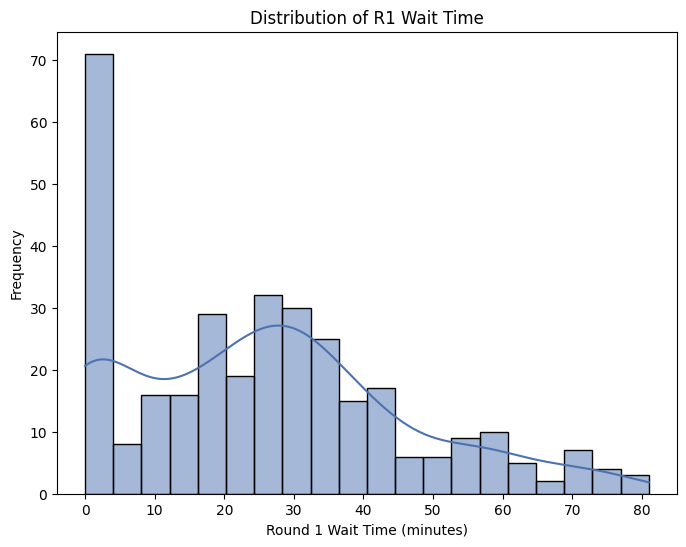

<Figure size 640x480 with 0 Axes>

In [ ]:
# Histogram of Wait Time
plt.figure(figsize=(8, 6))
sns.histplot(df['Before Charging WT R1'], bins=20, kde=True)
plt.title('Distribution of R1 Wait Time')
plt.xlabel('Round 1 Wait Time (minutes)')
plt.ylabel('Frequency')
plt.show()
plt.savefig('R1_Wait_time.png', dpi=300)
plt.show()

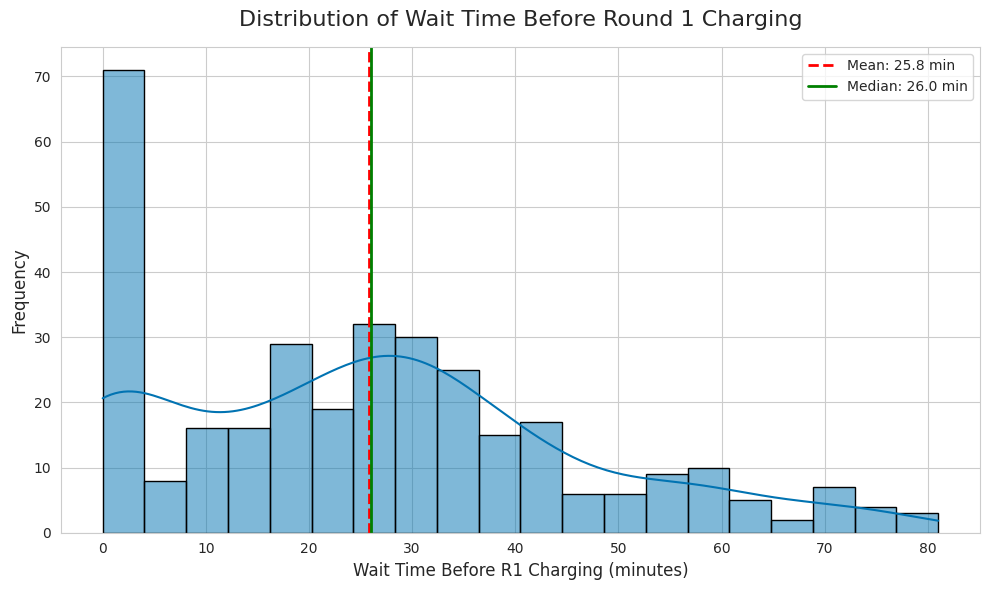

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Set style for consistency
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
hist_plot = sns.histplot(df['Before Charging WT R1'], bins=20, kde=True,
                         color=sns.color_palette("colorblind")[0], stat='count',
                         edgecolor='black', linewidth=1)

# Calculate statistics
mean_val = df['Before Charging WT R1'].mean()
median_val = df['Before Charging WT R1'].median()

# Add mean and median lines
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f} min')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.1f} min')

# Customize axes and title
plt.title("Distribution of Wait Time Before Round 1 Charging", fontsize=16, pad=15)
plt.xlabel("Wait Time Before R1 Charging (minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend(fontsize=10, loc='upper right')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure8_R1Wait_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

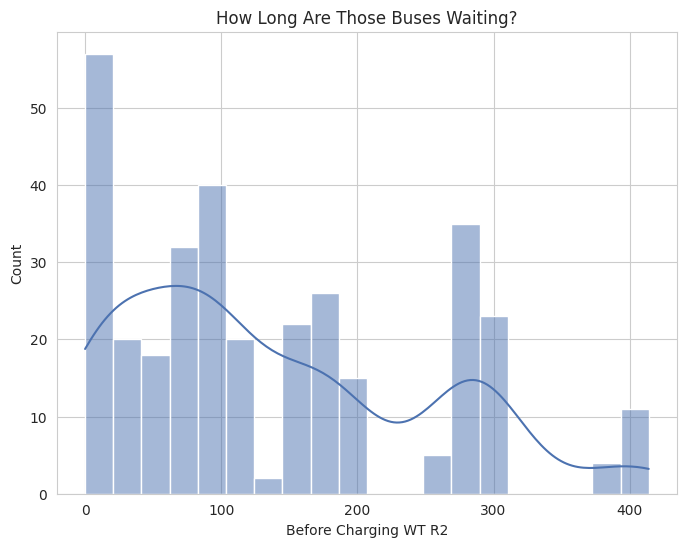

In [ ]:
# Histogram of Wait Time
plt.figure(figsize=(8, 6))
sns.histplot(df['Before Charging WT R2'], bins=20, kde=True)
plt.title('How Long Are Those Buses Waiting?')
plt.show()

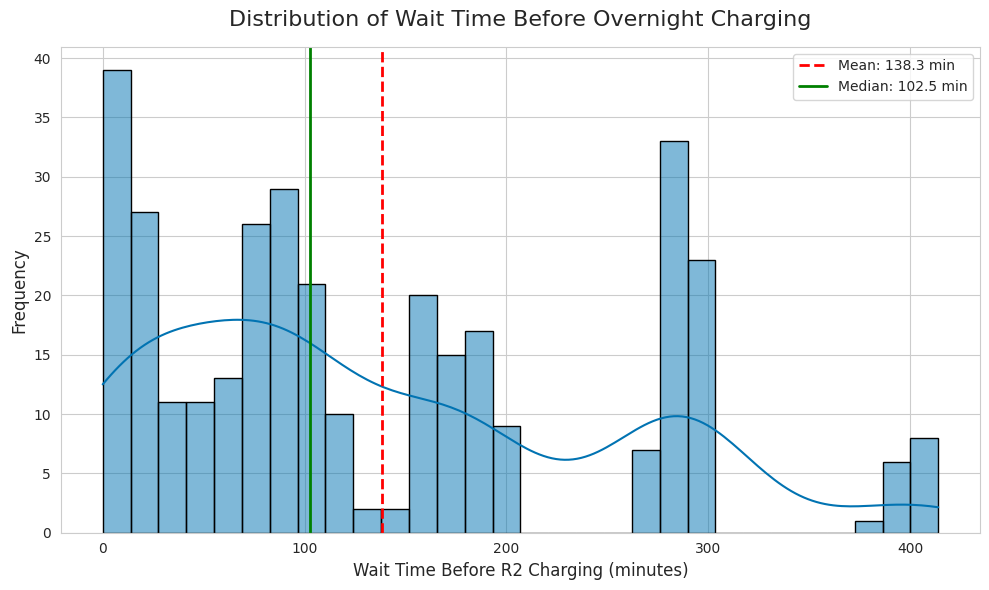

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is loaded
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Set style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
hist_plot = sns.histplot(df['Before Charging WT R2'], bins=30, kde=True,
                         color=sns.color_palette("colorblind")[0], stat='count',
                         edgecolor='black', linewidth=1)

# Calculate statistics
mean_val = df['Before Charging WT R2'].mean()
median_val = df['Before Charging WT R2'].median()

# Add mean and median lines
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f} min')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.1f} min')

# Customize axes and title
plt.title("Distribution of Wait Time Before Overnight Charging", fontsize=16, pad=15)
plt.xlabel("Wait Time Before R2 Charging (minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend(fontsize=10, loc='upper right')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure1_R2Wait_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

### Charging Durations

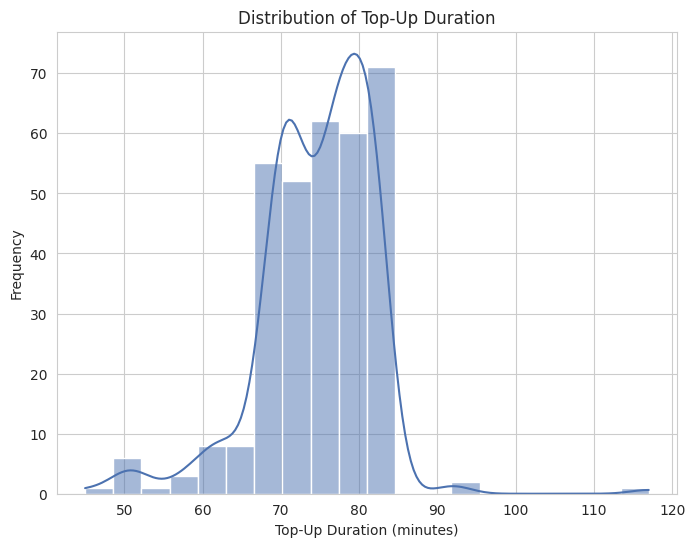

In [ ]:
# Repeat for Top-Up Dur and Wait Time
plt.figure(figsize=(8, 6))
sns.histplot(df['Top-Up Dur'], bins=20, kde=True)
plt.title('Distribution of Top-Up Duration')
plt.xlabel('Top-Up Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

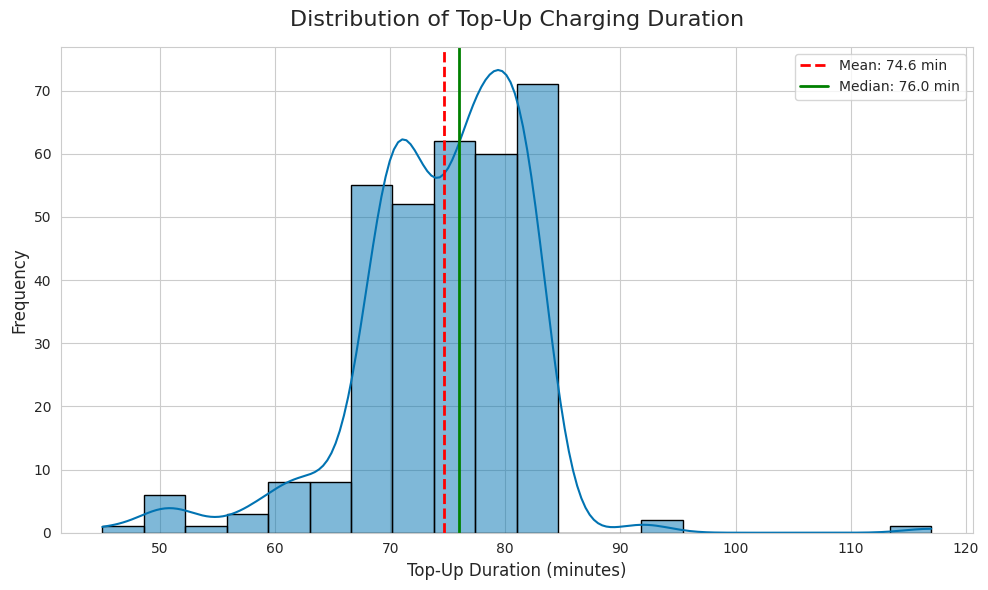

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Set style for consistency
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
hist_plot = sns.histplot(df['Top-Up Dur'], bins=20, kde=True, color=sns.color_palette("colorblind")[0],
                         stat='count', edgecolor='black', linewidth=1)

# Calculate statistics
mean_val = df['Top-Up Dur'].mean()
median_val = df['Top-Up Dur'].median()

# Add mean and median lines
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f} min')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.1f} min')

# Customize axes and title
plt.title("Distribution of Top-Up Charging Duration", fontsize=16, pad=15)
plt.xlabel("Top-Up Duration (minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend(fontsize=10, loc='upper right')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure5_TopUpDur_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

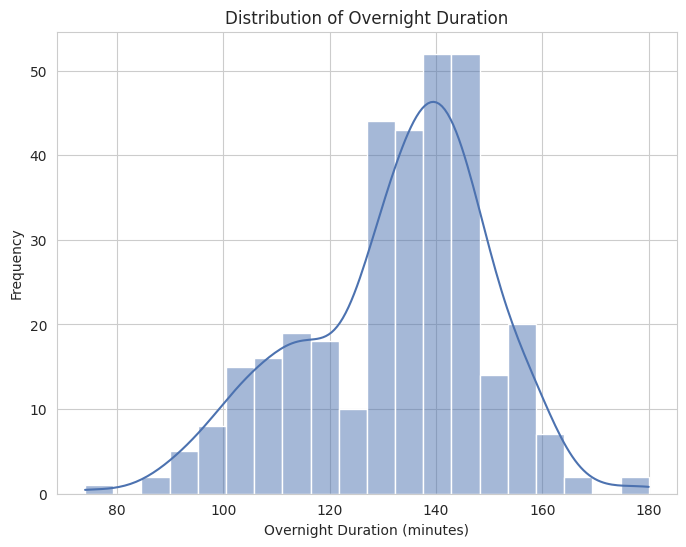

In [ ]:

plt.figure(figsize=(8, 6))
sns.histplot(df['Overnight Dur'], bins=20, kde=True)
plt.title('Distribution of Overnight Duration')
plt.xlabel('Overnight Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

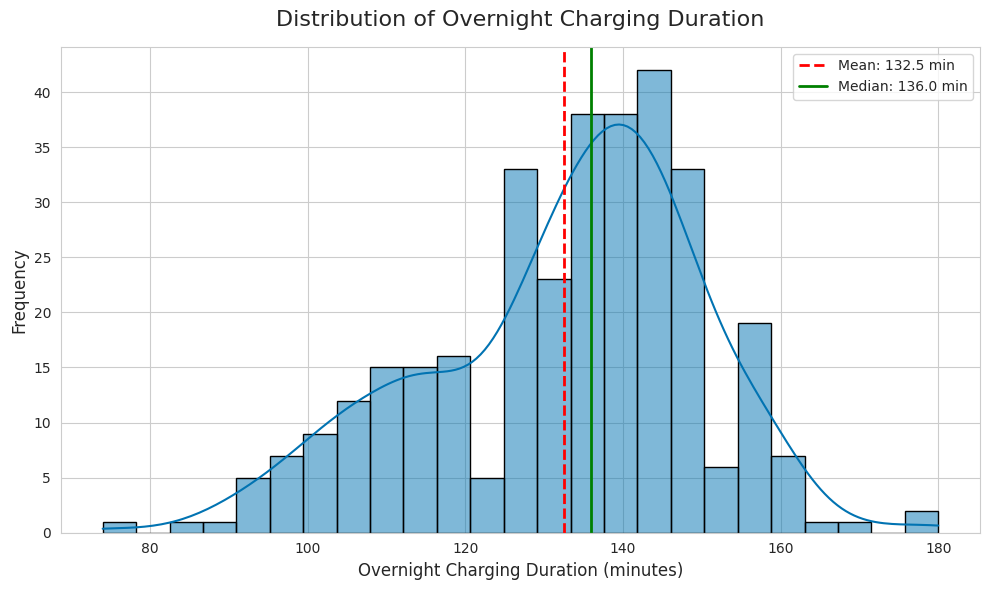

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Set style for consistency
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
hist_plot = sns.histplot(df['Overnight Dur'], bins=25, kde=True,
                         color=sns.color_palette("colorblind")[0], stat='count',
                         edgecolor='black', linewidth=1)

# Calculate statistics
mean_val = df['Overnight Dur'].mean()
median_val = df['Overnight Dur'].median()

# Add mean and median lines
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f} min')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.1f} min')

# Customize axes and title
plt.title("Distribution of Overnight Charging Duration", fontsize=16, pad=15)
plt.xlabel("Overnight Charging Duration (minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend(fontsize=10, loc='upper right')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure6_OvernightDur_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

### State of Charge

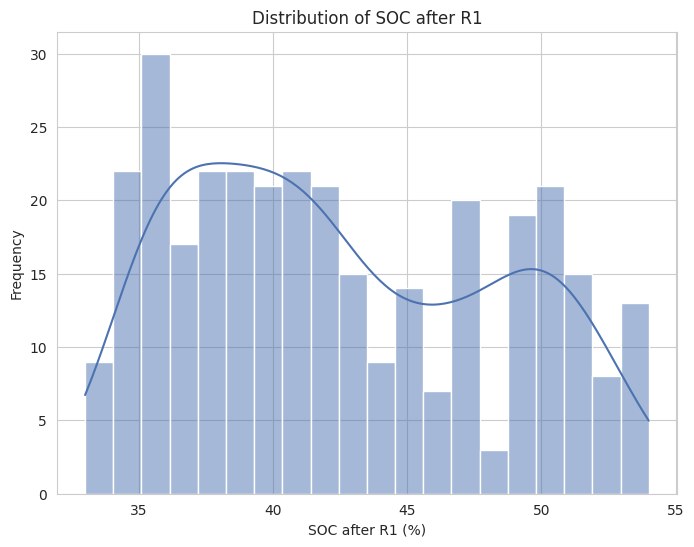

In [ ]:
# Histogram of SOC R1
plt.figure(figsize=(8, 6))
sns.histplot(df['SOC R1'], bins=20, kde=True)
plt.title('Distribution of SOC after R1')
plt.xlabel('SOC after R1 (%)')
plt.ylabel('Frequency')
plt.show()

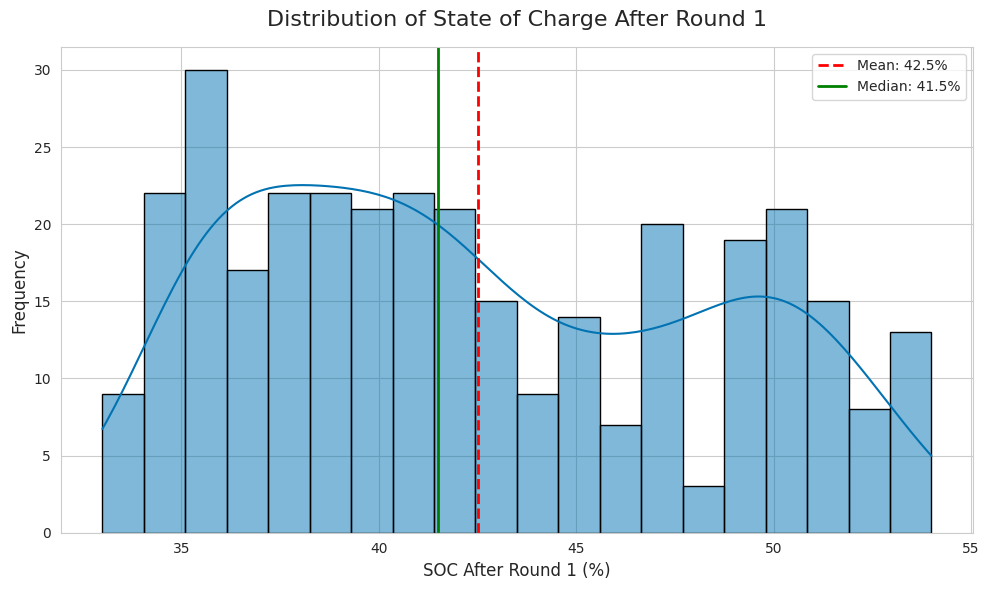

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is loaded
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Set style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
hist_plot = sns.histplot(df['SOC R1'], bins=20, kde=True,
                         color=sns.color_palette("colorblind")[0], stat='count',
                         edgecolor='black', linewidth=1)

# Calculate statistics
mean_val = df['SOC R1'].mean()
median_val = df['SOC R1'].median()

# Add mean and median lines
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}%')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.1f}%')

# Customize axes and title
plt.title("Distribution of State of Charge After Round 1", fontsize=16, pad=15)
plt.xlabel("SOC After Round 1 (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend(fontsize=10, loc='upper right')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure7_SOC_R1_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

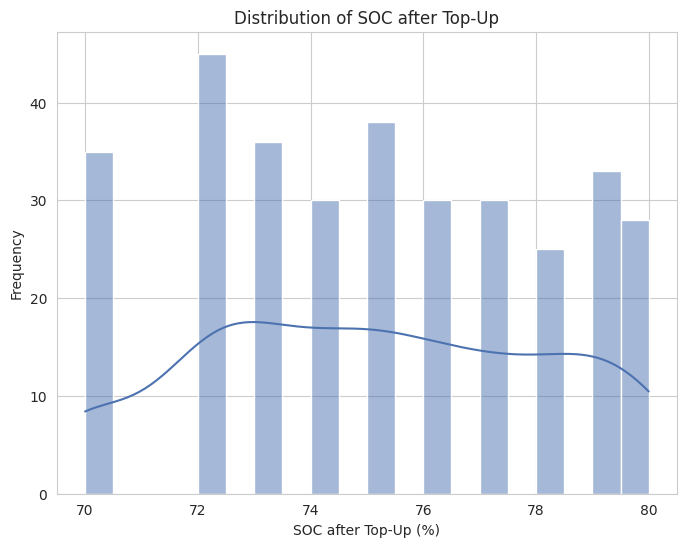

In [ ]:
# Histogram of SOC Top-Up
plt.figure(figsize=(8, 6))
sns.histplot(df['SOC Top-Up'], bins=20, kde=True)
plt.title('Distribution of SOC after Top-Up')
plt.xlabel('SOC after Top-Up (%)')
plt.ylabel('Frequency')
plt.show()

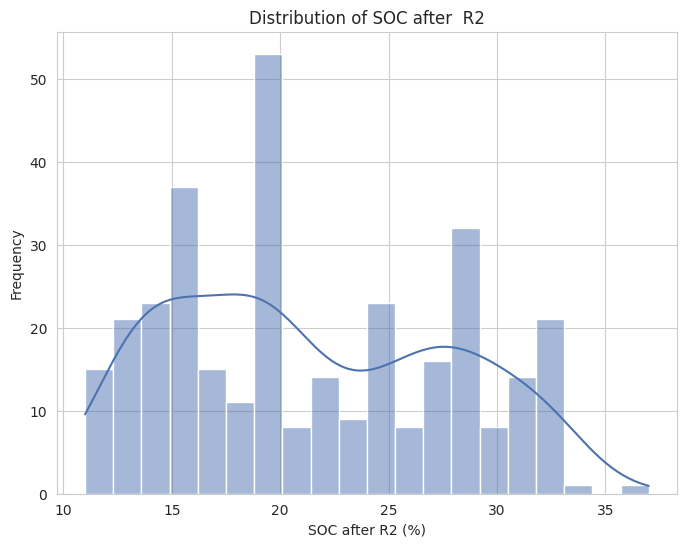

In [ ]:
# Histogram of SOC R2
plt.figure(figsize=(8, 6))
sns.histplot(df['SOC R2'], bins=20, kde=True)
plt.title('Distribution of SOC after  R2')
plt.xlabel('SOC after R2 (%)')
plt.ylabel('Frequency')
plt.show()

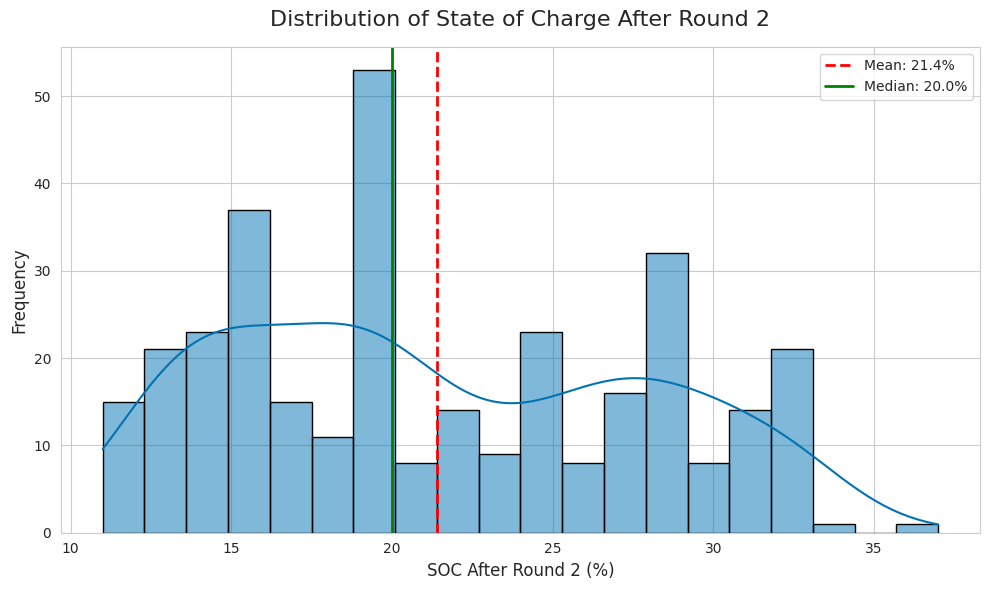

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Set style for consistency
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
hist_plot = sns.histplot(df['SOC R2'], bins=20, kde=True,
                         color=sns.color_palette("colorblind")[0], stat='count',
                         edgecolor='black', linewidth=1)

# Calculate statistics
mean_val = df['SOC R2'].mean()
median_val = df['SOC R2'].median()

# Add mean and median lines
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}%')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.1f}%')

# Customize axes and title
plt.title("Distribution of State of Charge After Round 2", fontsize=16, pad=15)
plt.xlabel("SOC After Round 2 (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend(fontsize=10, loc='upper right')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure9_SOC_R2_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

## Step 5: Exploring Relationships Between Variables

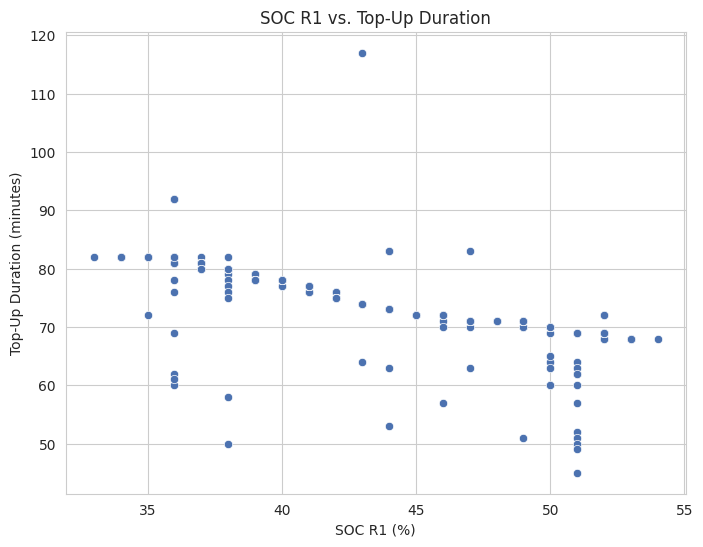

In [ ]:
# Scatter plot: SOC R1 vs. Top-Up Dur
plt.figure(figsize=(8, 6))
sns.scatterplot(x='SOC R1', y='Top-Up Dur', data=df)
plt.title('SOC R1 vs. Top-Up Duration')
plt.xlabel('SOC R1 (%)')
plt.ylabel('Top-Up Duration (minutes)')
plt.show()


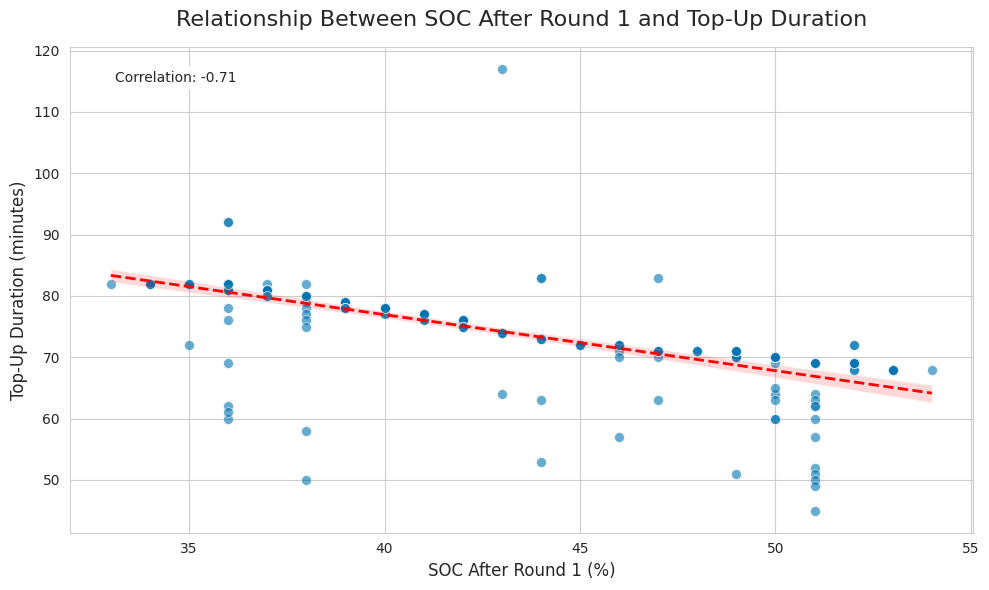

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming df is loaded
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Set style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Plot scatter with regression line
scatter_plot = sns.scatterplot(x='SOC R1', y='Top-Up Dur', data=df,
                               color=sns.color_palette("colorblind")[0], s=50, alpha=0.6)

# Add regression line
sns.regplot(x='SOC R1', y='Top-Up Dur', data=df, scatter=False, color='red',
            line_kws={'linewidth': 2, 'linestyle': '--'})

# Calculate correlation
corr, _ = stats.pearsonr(df['SOC R1'], df['Top-Up Dur'])

# Annotate correlation
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Customize axes and title
plt.title("Relationship Between SOC After Round 1 and Top-Up Duration", fontsize=16, pad=15)
plt.xlabel("SOC After Round 1 (%)", fontsize=12)
plt.ylabel("Top-Up Duration (minutes)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure10_SOC_R1_vs_TopUpDur_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [ ]:
correlation = df['SOC R1'].corr(df['Top-Up Dur'])
print(f'Correlation between SOC R1 and Top-Up Dur: {correlation:.2f}')

Correlation between SOC R1 and Top-Up Dur: -0.71


<ipython-input-44-74a1a38d22b8>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


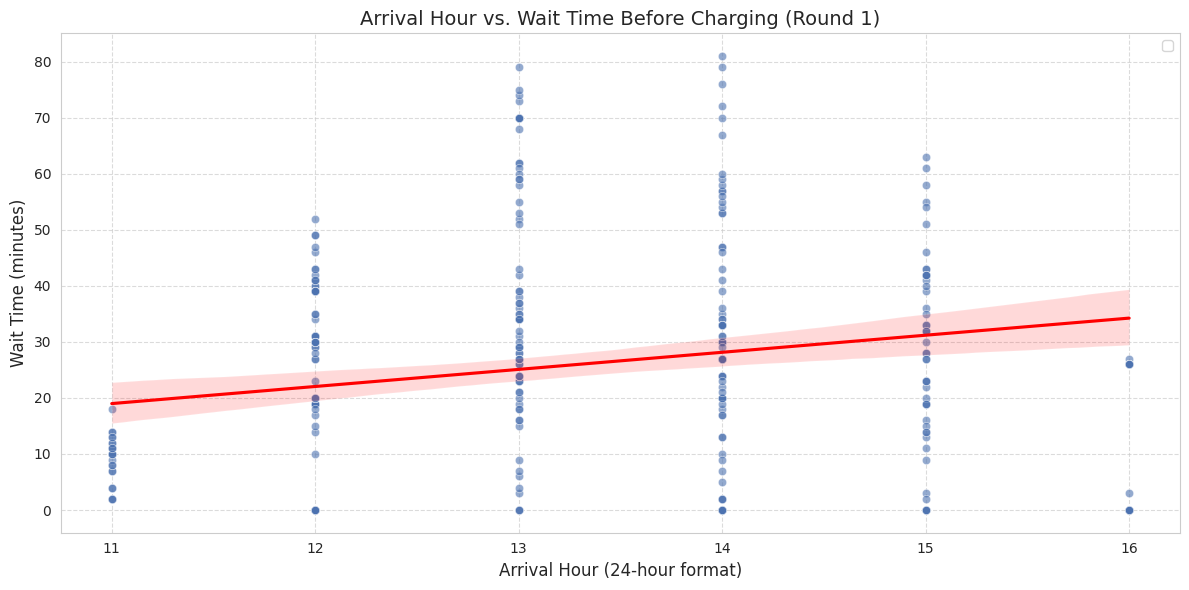

In [ ]:
from scipy.stats import pearsonr

# Ensure 'R1 Arrive_dt' is in datetime format
df['R1 Arrive_dt'] = pd.to_datetime(df['R1 Arrive_dt'], errors='coerce')

# Extract the arrival hour from 'R1 Arrive_dt'
df['Arrival Hour'] = df['R1 Arrive_dt'].dt.hour

# --- Plot 1: R1 Arrive vs. Wait Time ---
# Scatter plot with trend line to check correlation
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Arrival Hour', y='Before Charging WT R1', data=df, alpha=0.6)
sns.regplot(x='Arrival Hour', y='Before Charging WT R1', data=df, scatter=False, color='red', line_kws={'label': 'Trend Line'})
plt.title('Arrival Hour vs. Wait Time Before Charging (Round 1)', fontsize=14)
plt.xlabel('Arrival Hour (24-hour format)', fontsize=12)
plt.ylabel('Wait Time (minutes)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()




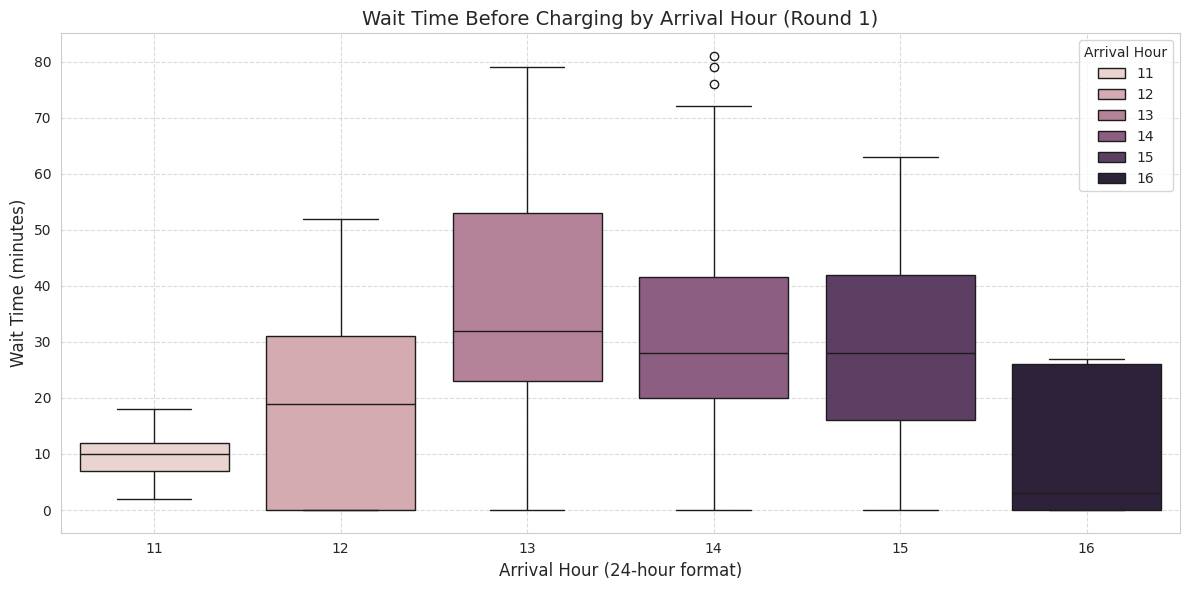

Correlation between Arrival Hour and Wait Time: 0.199 (p-value: 0.000)


In [ ]:
# Boxplot (as before, for additional insight)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Arrival Hour', y='Before Charging WT R1', data=df, hue='Arrival Hour')
plt.title('Wait Time Before Charging by Arrival Hour (Round 1)', fontsize=14)
plt.xlabel('Arrival Hour (24-hour format)', fontsize=12)
plt.ylabel('Wait Time (minutes)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('WT_Arrival_hour.png', dpi=300)
plt.show()

# Calculate correlation between Arrival Hour and Wait Time
corr, p_value = pearsonr(df['Arrival Hour'].dropna(), df['Before Charging WT R1'].dropna())
print(f"Correlation between Arrival Hour and Wait Time: {corr:.3f} (p-value: {p_value:.3f})")

<ipython-input-46-1e6f380d91f5>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='Arrival Hour', y='Before Charging WT R1', data=df,


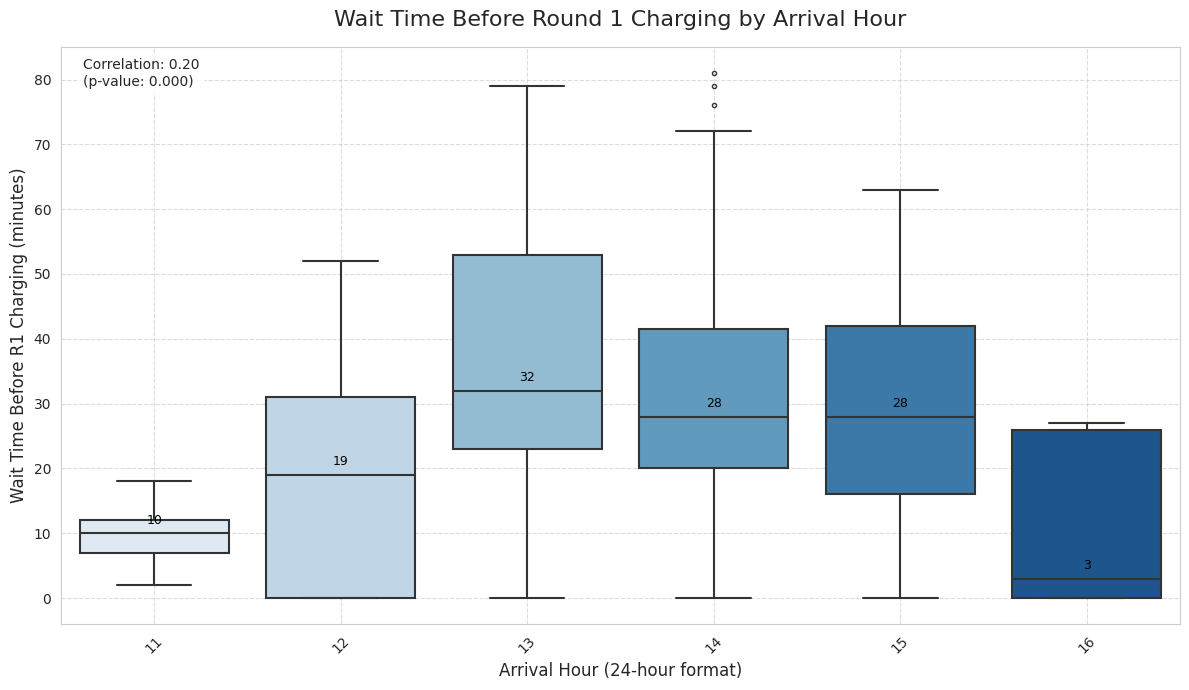

Pearson correlation between Arrival Hour and R1 Wait Time: 0.199
P-value: 0.000
Interpretation: The correlation is statistically significant (p < 0.05), suggesting a positive relationship.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming df is loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Set style for consistency
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(12, 7))

# Define a gradient palette for hours
palette = sns.color_palette("Blues", n_colors=len(df['Arrival Hour'].unique()))

# Plot box plot without redundant hue
box_plot = sns.boxplot(x='Arrival Hour', y='Before Charging WT R1', data=df,
                       palette=palette, linewidth=1.5, fliersize=3)

# Calculate correlation
corr, p_value = pearsonr(df['Arrival Hour'].dropna(), df['Before Charging WT R1'].dropna())

# Annotate correlation on plot
plt.text(0.02, 0.98, f'Correlation: {corr:.2f}\n(p-value: {p_value:.3f})',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Annotate median values
for i, hour in enumerate(sorted(df['Arrival Hour'].unique())):
    subset = df[df['Arrival Hour'] == hour]['Before Charging WT R1']
    median = subset.median()
    # Position text above box
    box_plot.text(i, median + 1, f'{median:.0f}', ha='center', va='bottom',
                  fontsize=9, color='black')

# Customize axes and title
plt.title("Wait Time Before Round 1 Charging by Arrival Hour", fontsize=16, pad=15)
plt.xlabel("Arrival Hour (24-hour format)", fontsize=12)
plt.ylabel("Wait Time Before R1 Charging (minutes)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Adjust gridlines
plt.grid(True, linestyle='--', alpha=0.7, which='both')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure11_R1Wait_by_ArrivalHour_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Print correlation with interpretation
print(f"Pearson correlation between Arrival Hour and R1 Wait Time: {corr:.3f}")
print(f"P-value: {p_value:.3f}")
print("Interpretation: ", end="")
if p_value < 0.05:
    print(f"The correlation is statistically significant (p < 0.05), suggesting a {'positive' if corr > 0 else 'negative'} relationship.")
else:
    print("The correlation is not statistically significant (p >= 0.05), indicating no clear linear relationship.")

## Step 6: Patterns Across Days and Routes

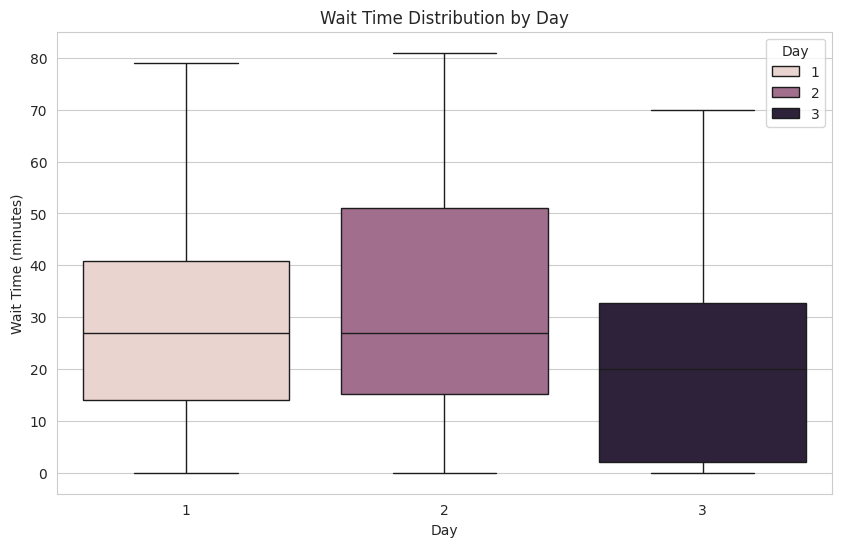

In [ ]:
# Box plot: Wait Time by Day
plt.figure(figsize=(10, 6))
sns.boxplot(x='Day', y='Before Charging WT R1', data=df, hue='Day')
plt.title('Wait Time Distribution by Day')
plt.xlabel('Day')
plt.ylabel('Wait Time (minutes)')
plt.savefig('WT_Day.png', dpi=300)
plt.show()

<ipython-input-48-cfa7ab6cd088>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='Day', y='Before Charging WT R1', data=df,


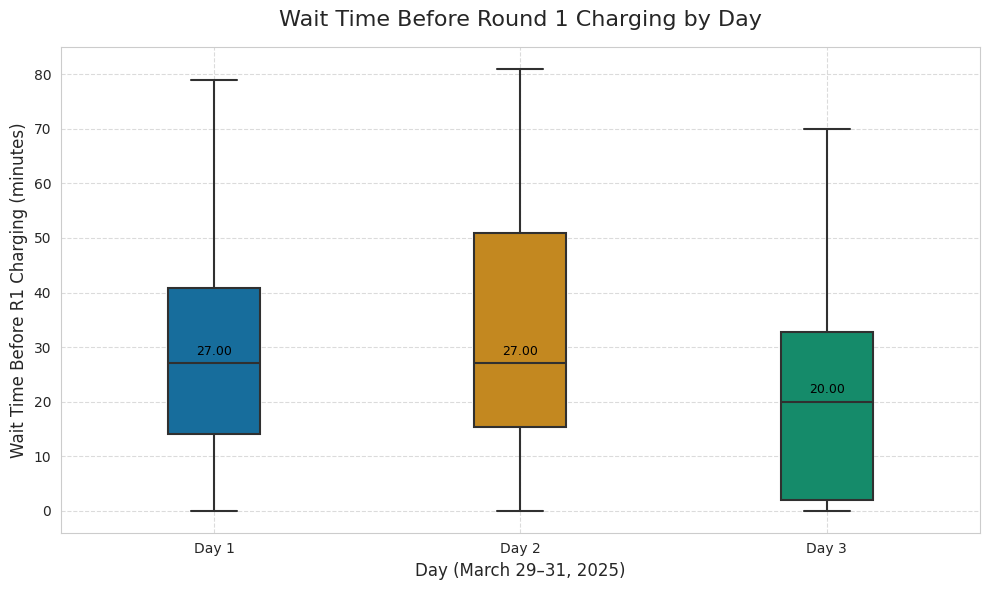

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Set style for consistency
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Define a colorblind-friendly palette for days
palette = sns.color_palette("colorblind", n_colors=3)  # Blue, orange, green

# Plot box plot without redundant hue
box_plot = sns.boxplot(x='Day', y='Before Charging WT R1', data=df,
                       palette=palette, linewidth=1.5, fliersize=3, width=0.3)

# Annotate median values
for i, day in enumerate(sorted(df['Day'].unique())):
    subset = df[df['Day'] == day]['Before Charging WT R1']
    median = subset.median()
    # Position text above box
    box_plot.text(i, median + 1, f'{median:.2f}', ha='center', va='bottom',
                  fontsize=9, color='black')

# Customize axes and title
plt.title("Wait Time Before Round 1 Charging by Day", fontsize=16, pad=15)
plt.xlabel("Day (March 29–31, 2025)", fontsize=12)
plt.ylabel("Wait Time Before R1 Charging (minutes)", fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=["Day 1", "Day 2", "Day 3"], fontsize=10)
plt.yticks(fontsize=10)

# Adjust gridlines
plt.grid(True, linestyle='--', alpha=0.7, which='both')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure12_R1Wait_by_Day_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

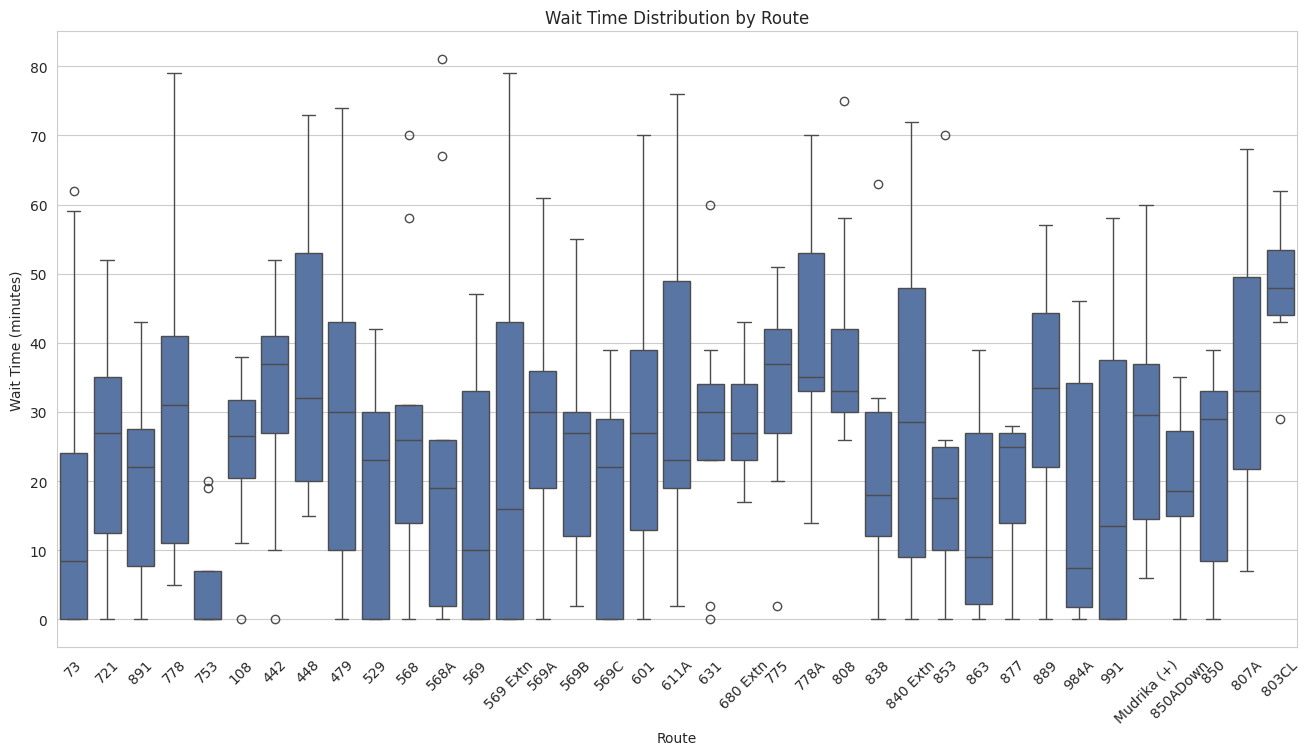

In [ ]:
# Box plot: Wait Time by Route
plt.figure(figsize=(16, 8))
sns.boxplot(x='Route', y='Before Charging WT R1', data=df)
plt.title('Wait Time Distribution by Route')
plt.xlabel('Route')
plt.ylabel('Wait Time (minutes)')
plt.xticks(rotation=45)
plt.show()

<ipython-input-50-699637f7bc42>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='Route', y='Before Charging WT R1', data=df_top_routes,


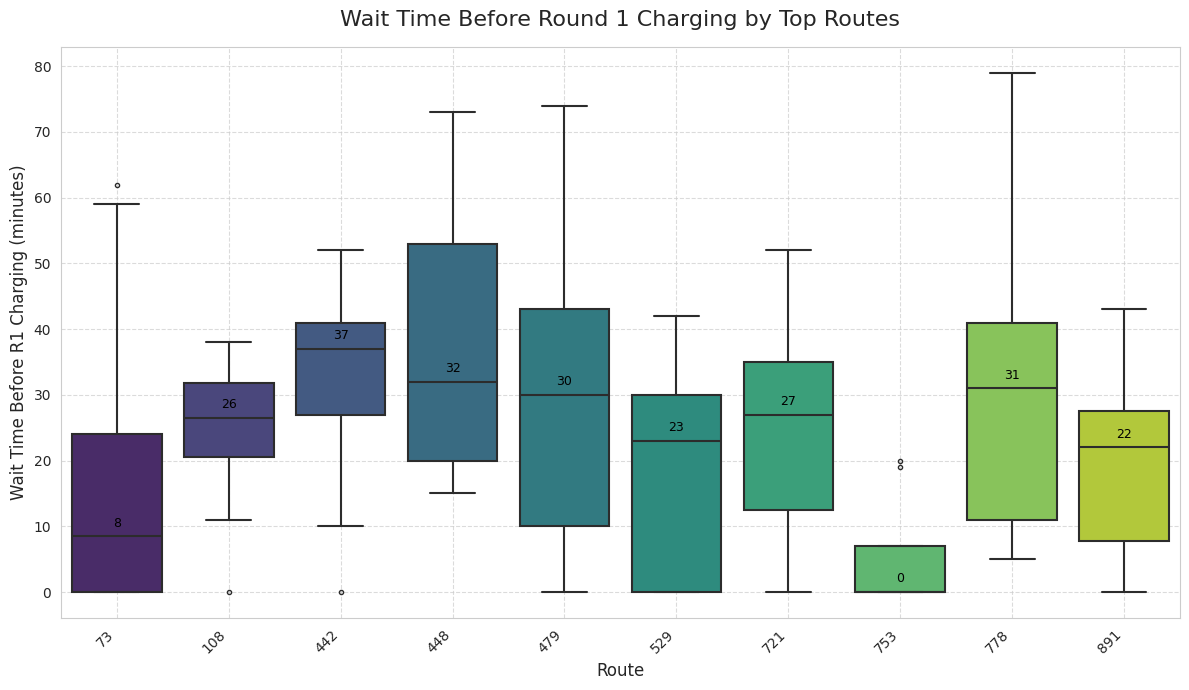

Top Routes by Bus Count:
Route
891    24
73     18
721    15
108    12
Name: count, dtype: int64


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is loaded
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Filter top routes by bus count (e.g., >=10 records or top 10)
route_counts = df['Route'].value_counts()
top_routes = route_counts[route_counts >= 5].index[:10]  # Top 10 or routes with >=10 records
df_top_routes = df[df['Route'].isin(top_routes)]

# Set style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(12, 7))

# Define a gradient palette for routes
palette = sns.color_palette("viridis", n_colors=len(top_routes))

# Plot box plot
box_plot = sns.boxplot(x='Route', y='Before Charging WT R1', data=df_top_routes,
                       palette=palette, linewidth=1.5, fliersize=3)

# Annotate median values
for i, route in enumerate(sorted(df_top_routes['Route'].unique())):
    subset = df_top_routes[df_top_routes['Route'] == route]['Before Charging WT R1']
    median = subset.median()
    # Position text above box
    box_plot.text(i, median + 1, f'{median:.0f}', ha='center', va='bottom',
                  fontsize=9, color='black')

# Customize axes and title
plt.title("Wait Time Before Round 1 Charging by Top Routes", fontsize=16, pad=15)
plt.xlabel("Route", fontsize=12)
plt.ylabel("Wait Time Before R1 Charging (minutes)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Adjust gridlines
plt.grid(True, linestyle='--', alpha=0.7, which='both')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure13_R1Wait_by_Route_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Print route counts for reference
print("Top Routes by Bus Count:")
print(route_counts[route_counts >= 10].head(10))

## Step 7: Charger Utilization Over Time

In [ ]:
df.head()

,Bus ID,Route,Day,R1 Depart_dt,R1 Arrive_dt,Duration_R1_N,SOC R1,Before Charging WT R1,Top-Up Start_dt,Top-Up End_dt,...,R2 Arrive_dt,Duration_R2_N,SOC R2,Before Charging WT R2,Overnight Start_dt,Overnight End_dt,Overnight Dur,SOC Overnight,Arrival Hour,SOC Top-Up Diff
0,1,73,1,2025-03-29 05:03:00,2025-03-29 11:42:00,399,43,18,2025-03-29 12:00:00,2025-03-29 13:14:00,...,2025-03-29 19:32:00,348,23,28,2025-03-29 20:00:00,2025-03-29 22:01:00,121,100,11,34
1,2,73,1,2025-03-29 05:17:00,2025-03-29 11:56:00,399,37,4,2025-03-29 12:00:00,2025-03-29 13:22:00,...,2025-03-29 19:51:00,359,18,9,2025-03-29 20:00:00,2025-03-29 22:21:00,141,100,11,38
2,3,73,1,2025-03-29 05:29:00,2025-03-29 12:03:00,394,39,0,2025-03-29 12:03:00,2025-03-29 13:22:00,...,2025-03-29 19:57:00,365,21,3,2025-03-29 20:00:00,2025-03-29 22:18:00,138,100,12,34
3,4,73,1,2025-03-29 05:41:00,2025-03-29 12:09:00,388,46,0,2025-03-29 12:09:00,2025-03-29 13:20:00,...,2025-03-29 20:38:00,408,26,92,2025-03-29 22:10:00,2025-03-29 23:57:00,107,100,12,32
4,5,721,1,2025-03-29 05:58:00,2025-03-29 12:14:00,376,35,0,2025-03-29 12:14:00,2025-03-29 13:36:00,...,2025-03-29 21:10:00,424,14,72,2025-03-29 22:22:00,2025-03-29 23:47:00,85,100,12,39


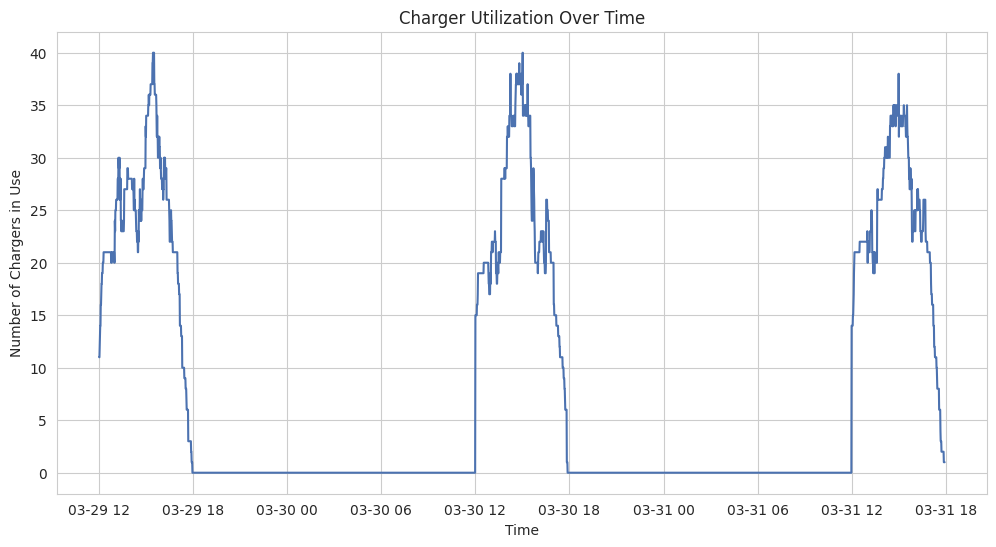

In [ ]:
import numpy as np

# Create a timeline
min_time = df['Top-Up Start_dt'].min()
max_time = df['Top-Up End_dt'].max()
timeline = pd.date_range(start=min_time, end=max_time, freq='min')

# Track charger usage
charger_usage = pd.Series(0, index=timeline)
for _, row in df.iterrows():
    start = row['Top-Up Start_dt']
    end = row['Top-Up End_dt']
    charger_usage[start:end] += 1

# Plot
plt.figure(figsize=(12, 6))
plt.plot(charger_usage.index, charger_usage.values)
plt.title('Charger Utilization Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Chargers in Use')
plt.show()

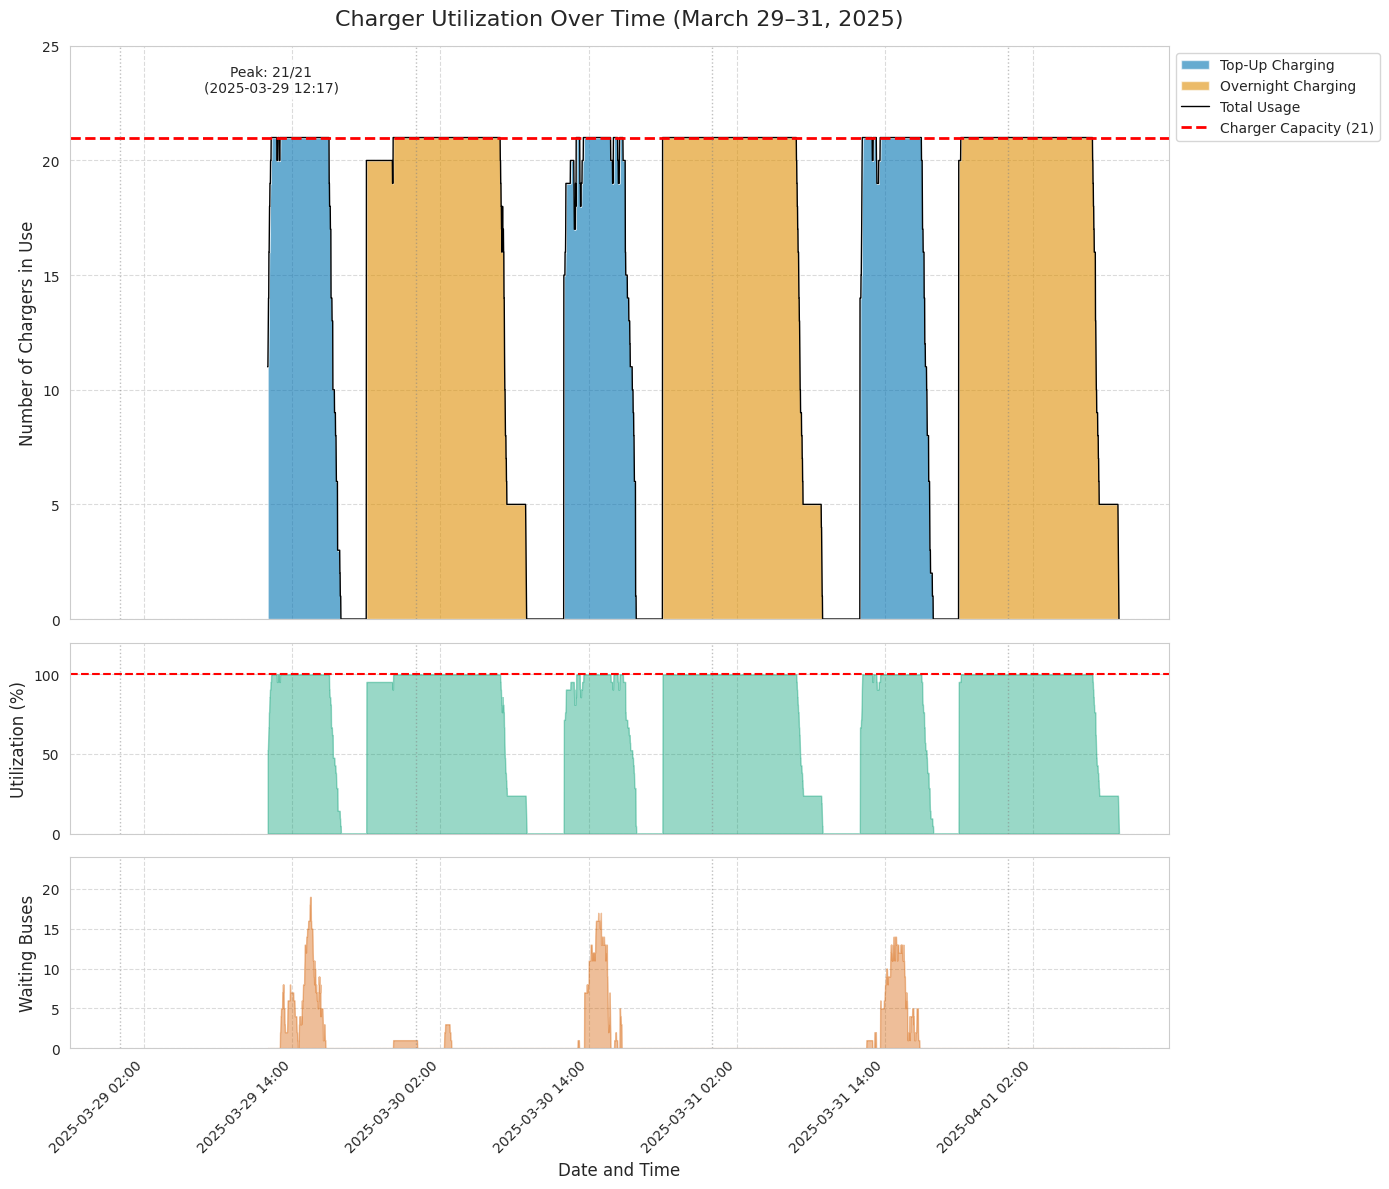

Peak Utilization: 21/21 chargers at 2025-03-29 12:17 (100.0%)
Average Utilization: 15.4 chargers (73.1%)
Max Utilization: 21 chargers (100.0%)
Max Waiting Buses: 19 at 2025-03-29 15:26:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Assuming df is loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Verify datetime columns
datetime_cols = ['Top-Up Start_dt', 'Top-Up End_dt', 'Overnight Start_dt', 'Overnight End_dt']
for col in datetime_cols:
    if not pd.api.types.is_datetime64_any_dtype(df[col]):
        raise ValueError(f"Column {col} is not in datetime format. Please convert to datetime64[ns].")

# Create list of charging sessions
sessions = []
for _, row in df.iterrows():
    # Top-up session
    if pd.notna(row['Top-Up Start_dt']) and pd.notna(row['Top-Up End_dt']) and row['Top-Up Start_dt'] <= row['Top-Up End_dt']:
        sessions.append({
            'start': row['Top-Up Start_dt'],
            'end': row['Top-Up End_dt'],
            'type': 'top-up'
        })
    # Overnight session
    if pd.notna(row['Overnight Start_dt']) and pd.notna(row['Overnight End_dt']) and row['Overnight Start_dt'] <= row['Overnight End_dt']:
        sessions.append({
            'start': row['Overnight Start_dt'],
            'end': row['Overnight End_dt'],
            'type': 'overnight'
        })

# Sort sessions by start time
sessions = sorted(sessions, key=lambda x: x['start'])

# Create timeline
min_time = min(s['start'] for s in sessions)
max_time = max(s['end'] for s in sessions)
timeline = pd.date_range(start=min_time.floor('min'), end=max_time.ceil('min'), freq='min')

# Track charger usage and waiting buses
total_chargers = 21
top_up_usage = pd.Series(0, index=timeline)
overnight_usage = pd.Series(0, index=timeline)
waiting_buses = pd.Series(0, index=timeline)

# Assign chargers (first-come, first-served, cap at 21)
active_sessions = []
for t in timeline:
    # Remove sessions that have ended
    active_sessions = [s for s in active_sessions if s['end'] > t]

    # Add new sessions starting at or before t
    while sessions and sessions[0]['start'] <= t:
        active_sessions.append(sessions.pop(0))

    # Count top-up and overnight sessions
    top_up_count = sum(1 for s in active_sessions if s['type'] == 'top-up')
    overnight_count = sum(1 for s in active_sessions if s['type'] == 'overnight')
    total_count = len(active_sessions)

    # Cap at total chargers
    if total_count > total_chargers:
        waiting_buses[t] = total_count - total_chargers
        # Allocate chargers proportionally (simplified)
        top_up_ratio = top_up_count / total_count if total_count > 0 else 0
        top_up_usage[t] = min(int(total_chargers * top_up_ratio), top_up_count)
        overnight_usage[t] = min(total_chargers - top_up_usage[t], overnight_count)
    else:
        top_up_usage[t] = top_up_count
        overnight_usage[t] = overnight_count
        waiting_buses[t] = 0

# Total usage (capped at 21)
total_usage = top_up_usage + overnight_usage

# Set style
sns.set_style("whitegrid")

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True,
                                   gridspec_kw={'height_ratios': [3, 1, 1]})

# Subplot 1: Stacked area plot
ax1.stackplot(timeline, top_up_usage, overnight_usage,
              labels=['Top-Up Charging', 'Overnight Charging'],
              colors=[sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[1]],
              alpha=0.6)
ax1.plot(timeline, total_usage, color='black', linewidth=1, label='Total Usage')
ax1.axhline(y=21, color='red', linestyle='--', linewidth=2, label='Charger Capacity (21)')

# Annotate peak utilization
peak_idx = total_usage.idxmax()
peak_value = total_usage.max()
peak_time = peak_idx.strftime('%Y-%m-%d %H:%M')
ax1.annotate(f'Peak: {peak_value:.0f}/21\n({peak_time})', xy=(peak_idx, peak_value),
             xytext=(peak_idx, peak_value + 2), arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Customize ax1
ax1.set_title("Charger Utilization Over Time (March 29–31, 2025)", fontsize=16, pad=15)
ax1.set_ylabel("Number of Chargers in Use", fontsize=12)
ax1.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1))
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(0, 25)

# Subplot 2: Utilization percentage
utilization_pct = (total_usage / 21) * 100
ax2.fill_between(timeline, utilization_pct, color=sns.color_palette("colorblind")[2], alpha=0.4)
ax2.axhline(y=100, color='red', linestyle='--', linewidth=1.5)

# Customize ax2
ax2.set_ylabel("Utilization (%)", fontsize=12)
ax2.set_ylim(0, 120)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_yticks([0, 50, 100])

# Subplot 3: Waiting buses
ax3.fill_between(timeline, waiting_buses, color=sns.color_palette("colorblind")[3], alpha=0.4)

# Customize ax3
ax3.set_ylabel("Waiting Buses", fontsize=12)
ax3.set_ylim(0, waiting_buses.max() + 5 if waiting_buses.max() > 0 else 10)
ax3.grid(True, linestyle='--', alpha=0.7)

# Shared x-axis formatting
ax3.set_xlabel("Date and Time", fontsize=12)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=12))
plt.xticks(rotation=45, ha='right', fontsize=10)
ax3.yaxis.set_tick_params(labelsize=10)

# Add day boundaries
for day in pd.date_range(start=min_time.floor('D'), end=max_time.floor('D'), freq='D'):
    for ax in [ax1, ax2, ax3]:
        ax.axvline(day, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure14_Charger_Utilization_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Print summary stats
print(f"Peak Utilization: {peak_value:.0f}/21 chargers at {peak_time} ({(peak_value/21*100):.1f}%)")
print(f"Average Utilization: {total_usage.mean():.1f} chargers ({(total_usage.mean()/21*100):.1f}%)")
print(f"Max Utilization: {total_usage.max():.0f} chargers ({(total_usage.max()/21*100):.1f}%)")
print(f"Max Waiting Buses: {waiting_buses.max():.0f} at {waiting_buses.idxmax()}")

<ipython-input-54-93c0a54cf339>:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  for hour in pd.date_range(start=day1_start, end=day1_end, freq='6H'):


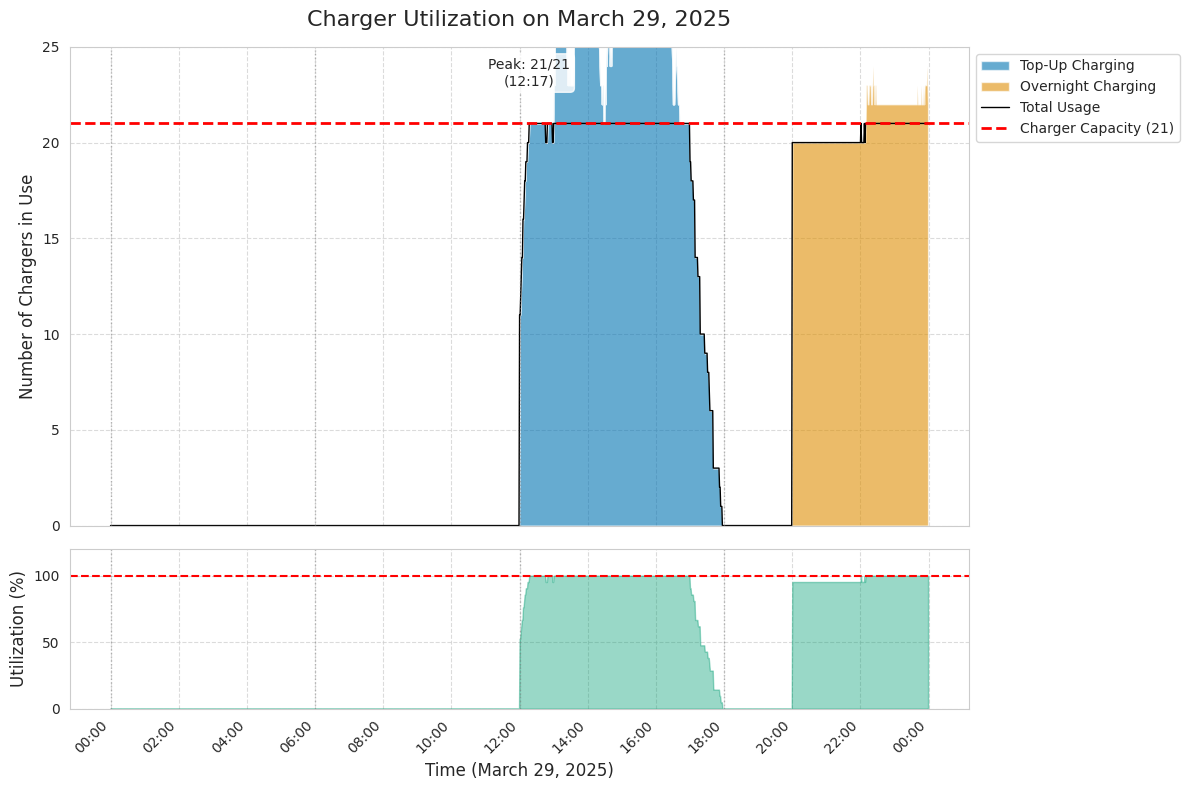

Peak Utilization: 21/21 chargers at 12:17 (100.0%)
Average Utilization: 8.1 chargers (38.5%)
Max Utilization: 21 chargers (100.0%)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Assuming df is loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Verify datetime columns
datetime_cols = ['Top-Up Start_dt', 'Top-Up End_dt', 'Overnight Start_dt', 'Overnight End_dt']
for col in datetime_cols:
    if not pd.api.types.is_datetime64_any_dtype(df[col]):
        raise ValueError(f"Column {col} is not in datetime format. Please convert to datetime64[ns].")

# Filter for Day 1 (March 29, 2025)
day1_start = pd.to_datetime('2025-03-29 00:00')
day1_end = pd.to_datetime('2025-03-29 23:59')
df_day1 = df[
    ((df['Top-Up Start_dt'].dt.date == day1_start.date()) |
     (df['Overnight Start_dt'].dt.date == day1_start.date()))
].copy()

# Create timeline for Day 1
min_time = min(df_day1['Top-Up Start_dt'].min(), df_day1['Overnight Start_dt'].min()).floor('min')
max_time = max(df_day1['Top-Up End_dt'].max(), df_day1['Overnight End_dt'].max()).ceil('min')
if pd.isna(min_time) or pd.isna(max_time):
    raise ValueError("No valid sessions found for Day 1.")
timeline = pd.date_range(start=day1_start, end=day1_end, freq='min')

# Track charger demand
total_chargers = 21
top_up_usage = pd.Series(0, index=timeline)
overnight_usage = pd.Series(0, index=timeline)
for _, row in df_day1.iterrows():
    # Top-up sessions
    top_start = row['Top-Up Start_dt']
    top_end = row['Top-Up End_dt']
    if pd.notna(top_start) and pd.notna(top_end) and top_start <= top_end:
        # Clip to Day 1
        start = max(top_start, day1_start)
        end = min(top_end, day1_end)
        if start < end:
            top_up_usage[start:end] += 1
    # Overnight sessions
    night_start = row['Overnight Start_dt']
    night_end = row['Overnight End_dt']
    if pd.notna(night_start) and pd.notna(night_end) and night_start <= night_end:
        start = max(night_start, day1_start)
        end = min(night_end, day1_end)
        if start < end:
            overnight_usage[start:end] += 1

# Total demand
total_demand = top_up_usage + overnight_usage

# Cap usage at 21 for display
total_usage = total_demand.clip(upper=total_chargers)

# Set style
sns.set_style("whitegrid")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Subplot 1: Stacked area plot
ax1.stackplot(timeline, top_up_usage, overnight_usage,
              labels=['Top-Up Charging', 'Overnight Charging'],
              colors=[sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[1]],
              alpha=0.6)
ax1.plot(timeline, total_usage, color='black', linewidth=1, label='Total Usage')
ax1.axhline(y=21, color='red', linestyle='--', linewidth=2, label='Charger Capacity (21)')

# Annotate peak utilization
peak_idx = total_usage.idxmax()
peak_value = total_usage.max()
peak_time = peak_idx.strftime('%H:%M')
ax1.annotate(f'Peak: {peak_value:.0f}/21\n({peak_time})', xy=(peak_idx, peak_value),
             xytext=(peak_idx, peak_value + 2), arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Customize ax1
ax1.set_title("Charger Utilization on March 29, 2025", fontsize=16, pad=15)
ax1.set_ylabel("Number of Chargers in Use", fontsize=12)
ax1.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1))
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(0, 25)

# Subplot 2: Utilization percentage
utilization_pct = (total_usage / total_chargers) * 100
ax2.fill_between(timeline, utilization_pct, color=sns.color_palette("colorblind")[2], alpha=0.4)
ax2.axhline(y=100, color='red', linestyle='--', linewidth=1.5)

# Customize ax2
ax2.set_ylabel("Utilization (%)", fontsize=12)
ax2.set_ylim(0, 120)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_yticks([0, 50, 100])

# Shared x-axis formatting
ax2.set_xlabel("Time (March 29, 2025)", fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.xticks(rotation=45, ha='right', fontsize=10)
ax2.yaxis.set_tick_params(labelsize=10)

# Add hour markers
for hour in pd.date_range(start=day1_start, end=day1_end, freq='6H'):
    for ax in [ax1, ax2]:
        ax.axvline(hour, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure14_Charger_Utilization_Day1_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Print summary stats
print(f"Peak Utilization: {peak_value:.0f}/21 chargers at {peak_time} ({(peak_value/21*100):.1f}%)")
print(f"Average Utilization: {total_usage.mean():.1f} chargers ({(total_usage.mean()/21*100):.1f}%)")
print(f"Max Utilization: {total_usage.max():.0f} chargers ({(total_usage.max()/21*100):.1f}%)")

<ipython-input-55-325b4e667aee>:114: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  for hour in pd.date_range(start=day1_start, end=day1_end, freq='6H'):


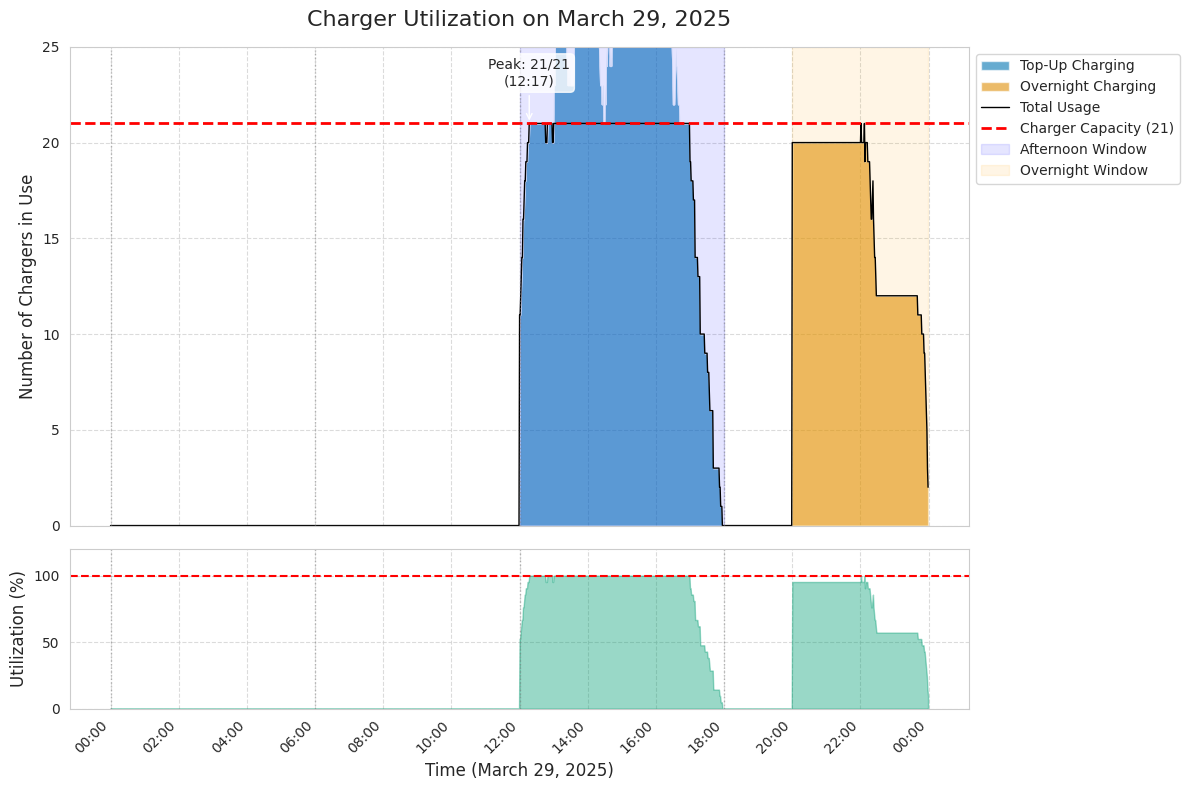

Peak Utilization: 21/21 chargers at 12:17 (100.0%)
Average Utilization: 7.4 chargers (35.3%)
Max Utilization: 21 chargers (100.0%)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Assuming df is loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Verify datetime and duration columns
datetime_cols = ['Top-Up Start_dt', 'Top-Up End_dt', 'Overnight Start_dt', 'Overnight End_dt']
duration_cols = ['Top-Up Dur', 'Overnight Dur']
for col in datetime_cols:
    if not pd.api.types.is_datetime64_any_dtype(df[col]):
        raise ValueError(f"Column {col} is not in datetime format. Please convert to datetime64[ns].")
for col in duration_cols:
    if col not in df.columns:
        raise ValueError(f"Column {col} not found in dataframe.")

# Filter for Day 1 (March 29, 2025)
day1_start = pd.to_datetime('2025-03-29 00:00')
day1_end = pd.to_datetime('2025-03-29 23:59')
df_day1 = df[
    ((df['Top-Up Start_dt'].dt.date == day1_start.date()) |
     (df['Overnight Start_dt'].dt.date == day1_start.date()))
].copy()

# Define charging windows
afternoon_window_start = pd.to_datetime('2025-03-29 12:00')
afternoon_window_end = pd.to_datetime('2025-03-29 18:00')
overnight_window_start = pd.to_datetime('2025-03-29 20:00')
overnight_window_end = pd.to_datetime('2025-03-30 09:00')  # Extends to next day

# Create timeline for full Day 1
timeline = pd.date_range(start=day1_start, end=day1_end, freq='min')

# Track charger usage
total_chargers = 21
top_up_usage = pd.Series(0, index=timeline)
overnight_usage = pd.Series(0, index=timeline)

# Populate usage based on start and end times within windows
for _, row in df_day1.iterrows():
    # Top-up sessions (afternoon window: 12:00–18:00)
    top_start = row['Top-Up Start_dt']
    top_end = row['Top-Up End_dt']
    if pd.notna(top_start) and pd.notna(top_end) and top_start <= top_end:
        start = max(top_start, afternoon_window_start)
        end = min(top_end, afternoon_window_end)
        if start < end:
            top_up_usage[start:end] += 1
    # Overnight sessions (overnight window: 20:00–09:00 next day, clipped to Day 1)
    night_start = row['Overnight Start_dt']
    night_end = row['Overnight End_dt']
    if pd.notna(night_start) and pd.notna(night_end) and night_start <= night_end:
        start = max(night_start, overnight_window_start)
        end = min(night_end, overnight_window_end)
        if start < end and end <= day1_end:  # Clip to Day 1 end
            overnight_usage[start:end] += 1

# Total demand and capped usage
total_demand = top_up_usage + overnight_usage
total_usage = total_demand.clip(upper=total_chargers)

# Set style
sns.set_style("whitegrid")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Subplot 1: Stacked area plot
ax1.stackplot(timeline, top_up_usage, overnight_usage,
              labels=['Top-Up Charging', 'Overnight Charging'],
              colors=[sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[1]],
              alpha=0.6)
ax1.plot(timeline, total_usage, color='black', linewidth=1, label='Total Usage')
ax1.axhline(y=21, color='red', linestyle='--', linewidth=2, label='Charger Capacity (21)')

# Annotate peak utilization
peak_idx = total_usage[total_usage == 21].idxmax()  # First peak at 21
peak_time = peak_idx.strftime('%H:%M')
ax1.annotate(f'Peak: 21/21\n({peak_time})', xy=(peak_idx, 21),
             xytext=(peak_idx, 21 + 2), arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Customize ax1
ax1.set_title("Charger Utilization on March 29, 2025", fontsize=16, pad=15)
ax1.set_ylabel("Number of Chargers in Use", fontsize=12)
ax1.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1))
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(0, 25)

# Subplot 2: Utilization percentage
utilization_pct = (total_usage / total_chargers) * 100
ax2.fill_between(timeline, utilization_pct, color=sns.color_palette("colorblind")[2], alpha=0.4)
ax2.axhline(y=100, color='red', linestyle='--', linewidth=1.5)

# Customize ax2
ax2.set_ylabel("Utilization (%)", fontsize=12)
ax2.set_ylim(0, 120)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_yticks([0, 50, 100])

# Shared x-axis formatting
ax2.set_xlabel("Time (March 29, 2025)", fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.xticks(rotation=45, ha='right', fontsize=10)
ax2.yaxis.set_tick_params(labelsize=10)

# Add hour markers and window boundaries
for hour in pd.date_range(start=day1_start, end=day1_end, freq='6H'):
    for ax in [ax1, ax2]:
        ax.axvline(hour, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax1.axvspan(afternoon_window_start, afternoon_window_end, color='blue', alpha=0.1, label='Afternoon Window')
ax1.axvspan(overnight_window_start, day1_end, color='orange', alpha=0.1, label='Overnight Window')
ax1.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1))

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure14_Charger_Utilization_Day1_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Print summary stats
print(f"Peak Utilization: 21/21 chargers at {peak_time} (100.0%)")
print(f"Average Utilization: {total_usage.mean():.1f} chargers ({(total_usage.mean()/21*100):.1f}%)")
print(f"Max Utilization: {total_usage.max():.0f} chargers (100.0%)")

## Step 8: Feature Engineering

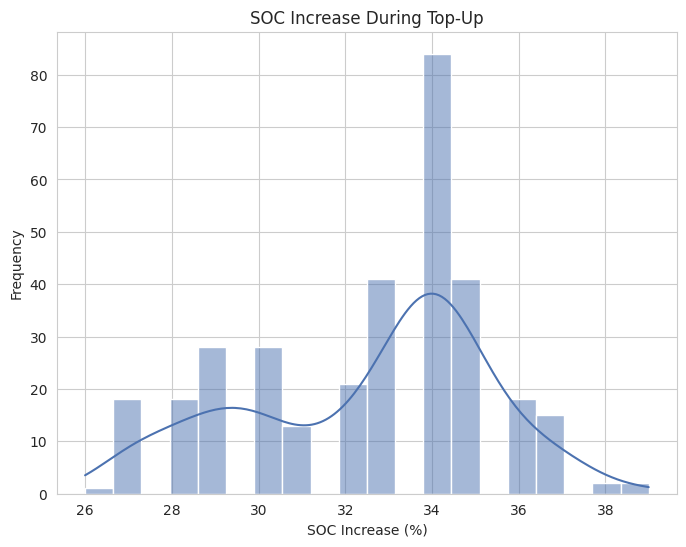

In [ ]:
# SOC difference
df['SOC Top-Up Diff'] = df['SOC Top-Up'] - df['SOC R1']

# Plot SOC Top-Up Diff
plt.figure(figsize=(8, 6))
sns.histplot(df['SOC Top-Up Diff'], bins=20, kde=True)
plt.title('SOC Increase During Top-Up')
plt.xlabel('SOC Increase (%)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Bus ID                 330 non-null    int64         
 1   Route                  330 non-null    object        
 2   Day                    330 non-null    int64         
 3   R1 Depart_dt           330 non-null    datetime64[ns]
 4   R1 Arrive_dt           330 non-null    datetime64[ns]
 5   Duration_R1_N          330 non-null    int64         
 6   SOC R1                 330 non-null    int64         
 7   Before Charging WT R1  330 non-null    int64         
 8   Top-Up Start_dt        330 non-null    datetime64[ns]
 9   Top-Up End_dt          330 non-null    datetime64[ns]
 10  Top-Up Dur             330 non-null    int64         
 11  SOC Top-Up             330 non-null    int64         
 12  R2 Depart_dt           330 non-null    datetime64[ns]
 13  R2 Ar

In [ ]:
df['R1 Arrive_dt'].dtype

dtype('<M8[ns]')

In [ ]:
# Compare wait times across days
mean_wait_by_day = df.groupby('Day')['Before Charging WT R1'].mean()
print(mean_wait_by_day)

Day
1    27.372727
2    30.954545
3    19.109091
Name: Before Charging WT R1, dtype: float64


## Step 9: Outlier Detection

In [ ]:
# Long wait times
long_waits = df[df['Before Charging WT R1'] > 120]
print(long_waits[['Bus ID', 'Day', 'Route', 'R1 Arrive_dt', 'Top-Up Start_dt', 'Before Charging WT R1']])

Empty DataFrame
Columns: [Bus ID, Day, Route, R1 Arrive_dt, Top-Up Start_dt, Before Charging WT R1]
Index: []


In [ ]:
df.to_excel('Cleaned_Data_After_EDA.xlsx', index=False)

## More Visuals

In [ ]:
import pandas as pd

df['Top-Up kWh'] = (df['SOC Top-Up'] - df['SOC R1']) * 324 / 100
df['Overnight kWh'] = (df['SOC Overnight'] - df['SOC R2']) * 324 / 100
energy_summary = pd.DataFrame({
    'Metric': ['Mean', 'SD', 'Total'],
    'Top-Up (kWh)': [df['Top-Up kWh'].mean(), df['Top-Up kWh'].std(), df['Top-Up kWh'].sum()],
    'Overnight (kWh)': [df['Overnight kWh'].mean(), df['Overnight kWh'].std(), df['Overnight kWh'].sum()]
})
print(energy_summary)
# Export to CSV, then format in Word as a table
energy_summary.to_csv("Table1_Energy.csv")

  Metric  Top-Up (kWh)  Overnight (kWh)
0   Mean    105.486545       254.644364
1     SD      9.156103        20.748113
2  Total  34810.560000     84032.640000


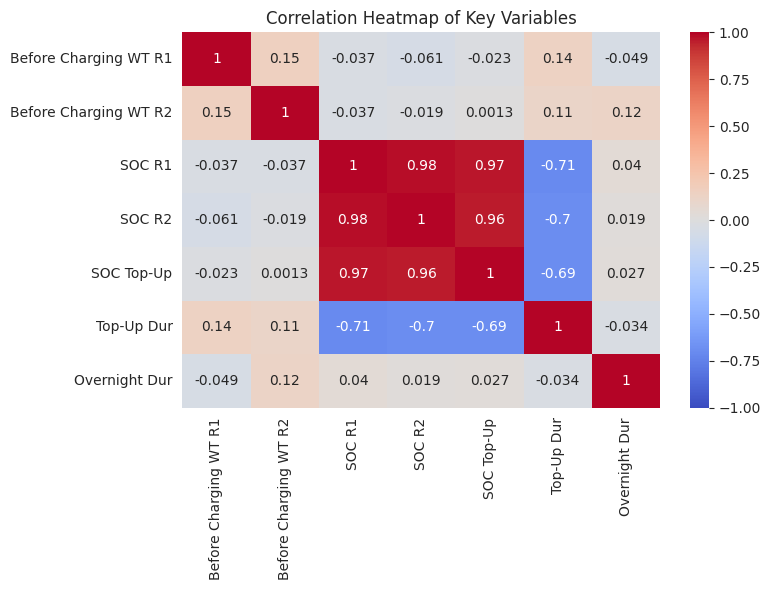

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_vars = df[['Before Charging WT R1', 'Before Charging WT R2', 'SOC R1', 'SOC R2',
                'SOC Top-Up', 'Top-Up Dur', 'Overnight Dur']]
plt.figure(figsize=(8, 6))
sns.heatmap(corr_vars.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Key Variables")
plt.tight_layout()
plt.savefig("Figure4_Heatmap.png", dpi=300)
plt.show()

In [ ]:
top_routes = df['Route'].value_counts().head(5).index
route_summary = df[df['Route'].isin(top_routes)].groupby('Route')[['Before Charging WT R1',
    'Before Charging WT R2', 'Top-Up Dur', 'Overnight Dur']].mean().reset_index()
print(route_summary)
route_summary.to_csv("Table2_Routes.csv")

   Route  Before Charging WT R1  Before Charging WT R2  Top-Up Dur  \
0     73              16.555556              62.944444   77.388889   
1    108              24.333333             113.500000   73.583333   
2    721              23.266667              93.600000   75.733333   
3    778              33.000000             223.333333   76.333333   
4    891              20.416667             212.708333   72.916667   

   Overnight Dur  
0     133.388889  
1     119.666667  
2     122.733333  
3     141.333333  
4     141.541667  


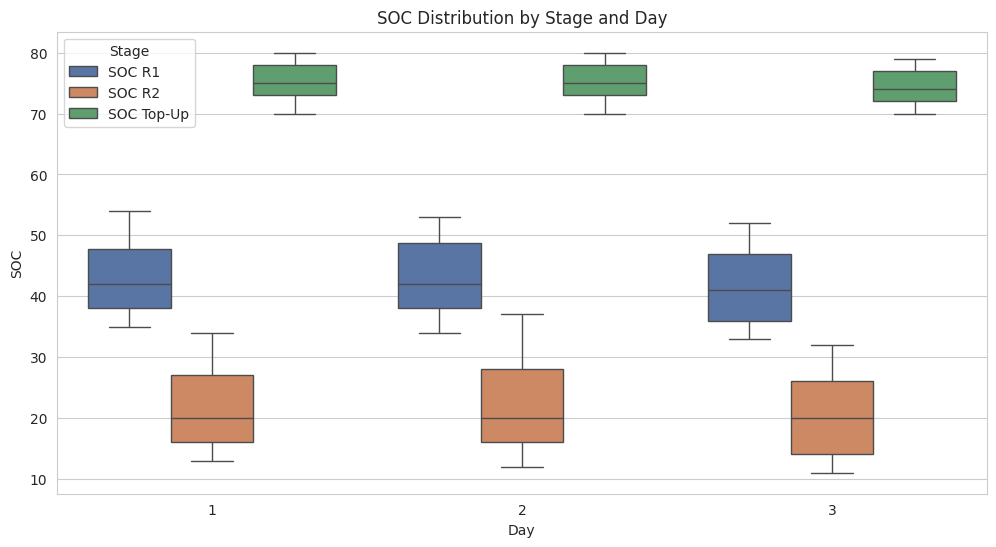

In [ ]:
plt.figure(figsize=(12, 6))
soc_melt = pd.melt(df, id_vars=['Day'], value_vars=['SOC R1', 'SOC R2', 'SOC Top-Up'],
                   var_name='Stage', value_name='SOC')
sns.boxplot(x='Day', y='SOC', hue='Stage', data=soc_melt)
plt.title("SOC Distribution by Stage and Day")
plt.savefig("Figure3_SOC.png", dpi=300)
plt.show()

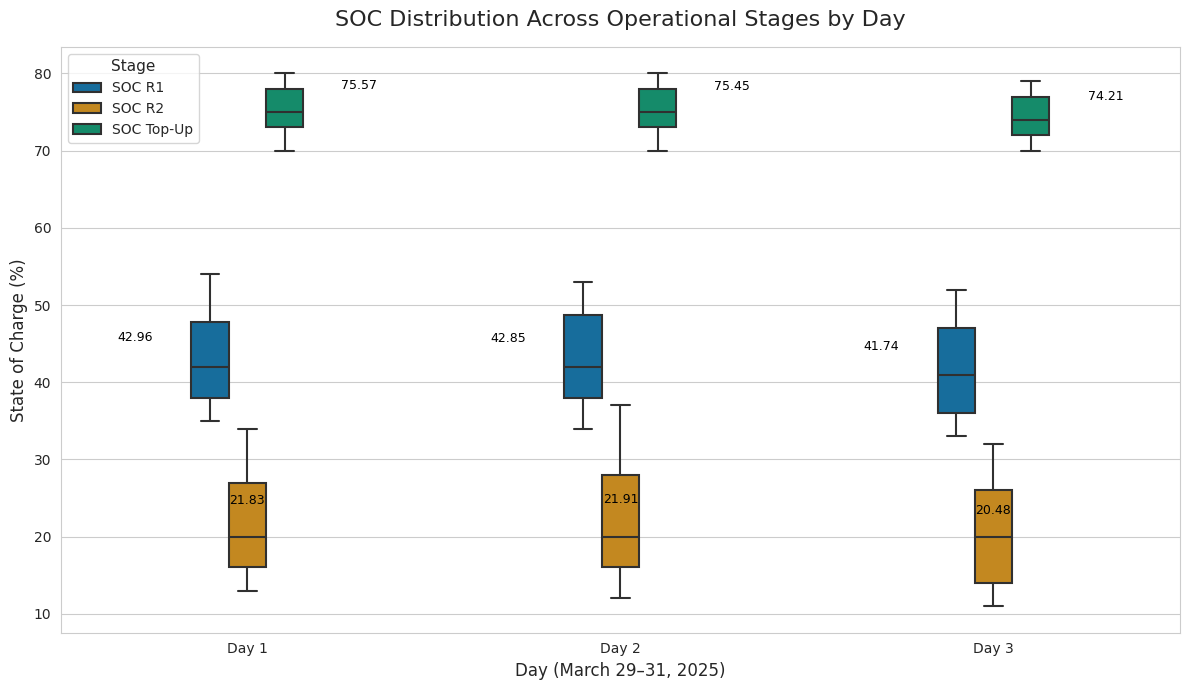

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Set style for better aesthetics
sns.set_style("whitegrid")

# Create figure with adjusted size
plt.figure(figsize=(12, 7))

# Melt dataframe to long format for SOC stages
soc_melt = pd.melt(df, id_vars=['Day'], value_vars=['SOC R1', 'SOC R2', 'SOC Top-Up'],
                   var_name='Stage', value_name='SOC')

# Define a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=3)  # Blue, orange, green

# Create box plot with customizations
box_plot = sns.boxplot(x='Day', y='SOC', hue='Stage', data=soc_melt, palette=palette,
                       linewidth=1.5, fliersize=3, width=0.3)

# Customize axes
plt.title("SOC Distribution Across Operational Stages by Day", fontsize=16, pad=15)
plt.xlabel("Day (March 29–31, 2025)", fontsize=12)
plt.ylabel("State of Charge (%)", fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=["Day 1", "Day 2", "Day 3"], fontsize=10)
plt.yticks(fontsize=10)

# Adjust legend
plt.legend(title="Stage", fontsize=10, title_fontsize=11, loc='upper left',
          bbox_to_anchor=(0, 1))

# Annotate median values
for i, day in enumerate([1, 2, 3]):
    for j, stage in enumerate(['SOC R1', 'SOC R2', 'SOC Top-Up']):
        # Filter data for current day and stage
        subset = soc_melt[(soc_melt['Day'] == day) & (soc_melt['Stage'] == stage)]
        median = subset['SOC'].median()
        mean = subset['SOC'].mean()
        # Position text above box (adjust y based on median)

        box_plot.text(i + j*0.3 - 0.3, mean + 2, f'{mean:.2f}',
                      ha='center', va='bottom', fontsize=9, color='black')

# Tight layout to prevent clipping
plt.tight_layout()

# Save high-resolution figure
plt.savefig("Figure3_SOC_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

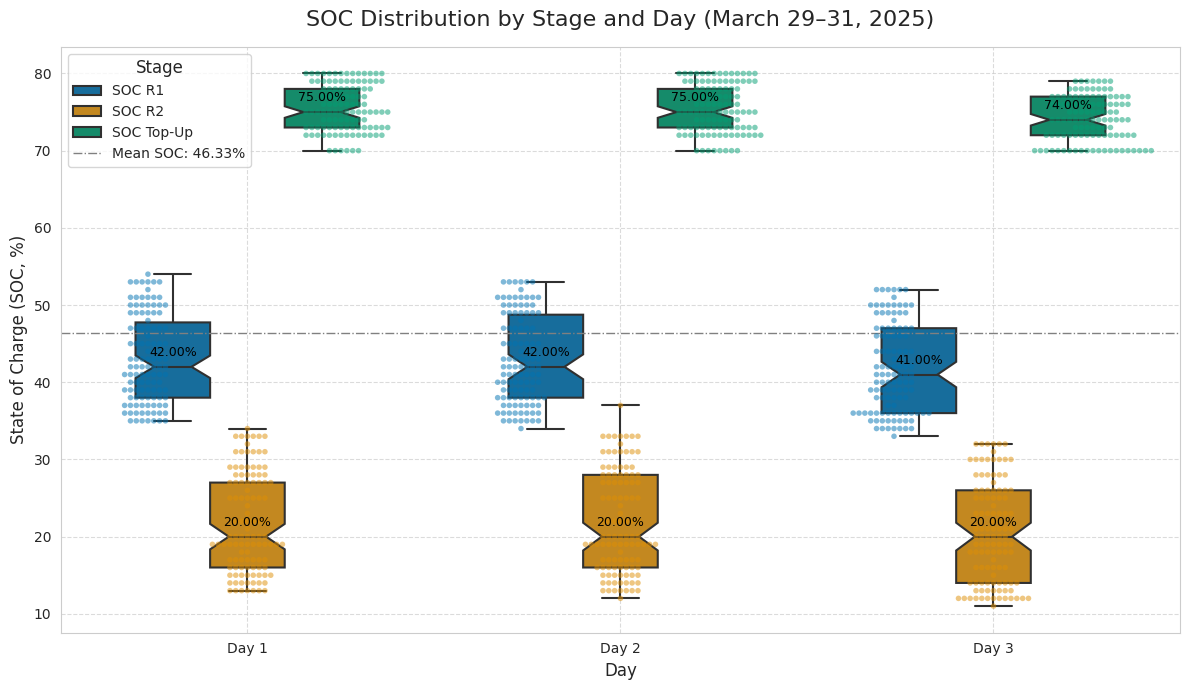

Median SOC by Stage and Day:
Day  Stage     
1    SOC R1        42.0
     SOC R2        20.0
     SOC Top-Up    75.0
2    SOC R1        42.0
     SOC R2        20.0
     SOC Top-Up    75.0
3    SOC R1        41.0
     SOC R2        20.0
     SOC Top-Up    74.0
Name: SOC, dtype: float64

Overall Mean SOC: 46.33%


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is loaded; if not, uncomment below
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Melt the dataframe for SOC stages
soc_melt = pd.melt(df, id_vars=['Day'], value_vars=['SOC R1', 'SOC R2', 'SOC Top-Up'],
                   var_name='Stage', value_name='SOC')

# Set style for consistency
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(12, 7))

# Define a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=3)  # Blue, orange, green

# Plot enhanced box plot with notches and swarm points
box_plot = sns.boxplot(x='Day', y='SOC', hue='Stage', data=soc_melt,
                       palette=palette, notch=True, linewidth=1.5, fliersize=3, width=0.6)
sns.swarmplot(x='Day', y='SOC', hue='Stage', data=soc_melt,
              palette=palette, size=4, dodge=True, alpha=0.5, legend=False)

# Annotate median values
for i, day in enumerate(sorted(soc_melt['Day'].unique())):
    for j, stage in enumerate(soc_melt['Stage'].unique()):
        subset = soc_melt[(soc_melt['Day'] == day) & (soc_melt['Stage'] == stage)]['SOC']
        median = subset.median()
        # Position text above box, adjusted for hue
        box_plot.text(i + (j - 1) * 0.2, median + 1, f'{median:.2f}%',
                      ha='center', va='bottom', fontsize=9, color='black')

# Add mean reference line
mean_soc = soc_melt['SOC'].mean()
plt.axhline(y=mean_soc, color='gray', linestyle='-.', linewidth=1,
            label=f'Mean SOC: {mean_soc:.2f}%')

# Customize axes and title
plt.title("SOC Distribution by Stage and Day (March 29–31, 2025)", fontsize=16, pad=15)
plt.xlabel("Day", fontsize=12)
plt.ylabel("State of Charge (SOC, %)", fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=["Day 1", "Day 2", "Day 3"], rotation=0, fontsize=10)
plt.yticks(fontsize=10)

# Customize legend
plt.legend(title='Stage', title_fontsize=12, fontsize=10, loc='upper left',
           bbox_to_anchor=(0, 1))

# Adjust gridlines
plt.grid(True, linestyle='--', alpha=0.7, which='both')

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("Figure3_SOC_Enhanced.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Print summary stats
print("Median SOC by Stage and Day:")
print(soc_melt.groupby(['Day', 'Stage'])['SOC'].median())
print(f"\nOverall Mean SOC: {mean_soc:.2f}%")

In [ ]:
df[['Top-Up kWh','Overnight kWh']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Top-Up kWh,330.0,105.486545,9.156103,84.24,97.20,106.92,110.16,126.36
Overnight kWh,330.0,254.644364,20.748113,204.12,236.52,259.20,272.16,288.36


In [ ]:
import pandas as pd

# Assuming df is loaded
# df = pd.read_excel("Cleaned_Data_after_EDA.xlsx")

# Calculate energy consumption
df['Top-Up kWh'] = (df['SOC Top-Up'] - df['SOC R1']) * 324 / 100
df['Overnight kWh'] = (df['SOC Overnight'] - df['SOC R2']) * 324 / 100

# Create energy summary
energy_summary = pd.DataFrame({
    'Metric': ['Mean', 'SD', 'Total'],
    'Top-Up (kWh)': [df['Top-Up kWh'].mean(), df['Top-Up kWh'].std(), df['Top-Up kWh'].sum()],
    'Overnight (kWh)': [df['Overnight kWh'].mean(), df['Overnight kWh'].std(), df['Overnight kWh'].sum()]
})

# Validation check
expected_topup_mean = (75.08 - 42.52) * 324 / 100
expected_overnight_mean = (100 - 21.41) * 324 / 100
print(f"Expected Top-Up Mean: {expected_topup_mean:.2f} kWh")
print(f"Expected Overnight Mean: {expected_overnight_mean:.2f} kWh")
print(f"Calculated Summary:\n{energy_summary}")

# Save for report
energy_summary.to_csv('Energy_Summary.csv', index=False)

Expected Top-Up Mean: 105.49 kWh
Expected Overnight Mean: 254.63 kWh
Calculated Summary:
  Metric  Top-Up (kWh)  Overnight (kWh)
0   Mean    105.486545       254.644364
1     SD      9.156103        20.748113
2  Total  34810.560000     84032.640000


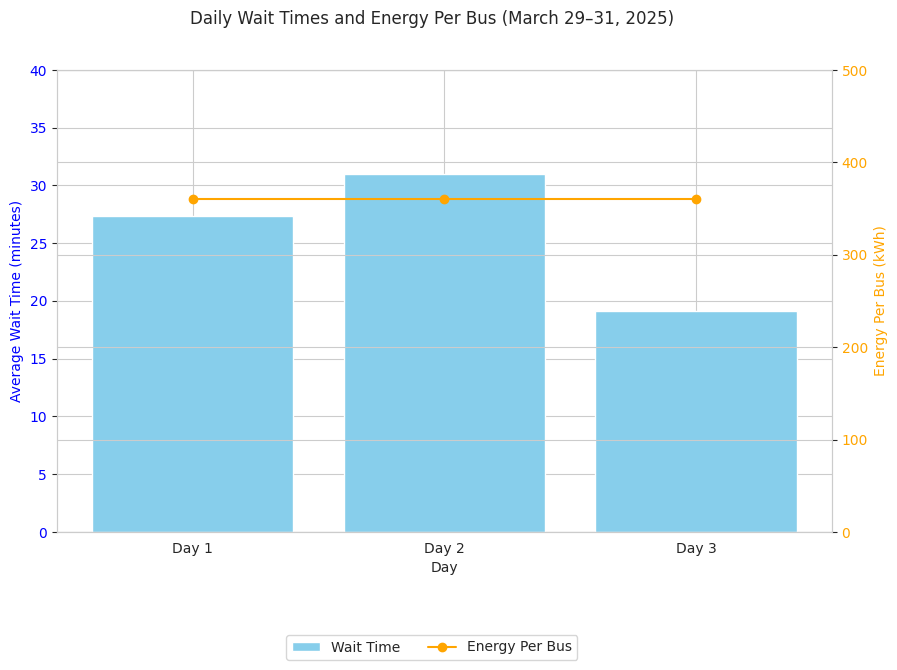

In [ ]:
import matplotlib.pyplot as plt

days = ['Day 1', 'Day 2', 'Day 3']
wait_times = [27.37, 30.95, 19.11]
energy_per_bus = [360.13, 360.13, 360.13]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(days, wait_times, color='skyblue', label='Wait Time')
ax1.set_xlabel('Day')
ax1.set_ylabel('Average Wait Time (minutes)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 40)

ax2 = ax1.twinx()
ax2.plot(days, energy_per_bus, color='orange', marker='o', label='Energy Per Bus')
ax2.set_ylabel('Energy Per Bus (kWh)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 500)

fig.suptitle('Daily Wait Times and Energy Per Bus (March 29–31, 2025)')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.savefig('Figure1_Daily_Wait_Energy.png', dpi=300)
plt.show()